# <center>Дипломный проект.</center> 
# <center> Модель прогнозирования стоимости жилья для агентства недвижимости.</center> 

## 1. Постановка задачи (Business Understanding)  

**Описание проекта**  
Агентство недвижимости столкнулось с проблемой: риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.  

Типовая задача из области Data Science, основанная на реальных данных об объектах недвижимости в США.

**Бизнес-задача**  
Повысить прибыль агентства недвижимости за счет увеличения скорости реакции риелторов и качества их работы при продаже объектов недвижимости.  

**Техническая задача для специалиста Data Science**  
Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок на продажу объектов недвижимости.  

**Основные цели проекта:**
1. Произвести предобработку и разведывательный анализ набора реальных данных (обработать пропуски, дубликаты и выбросы, устранить ошибки ввода, расшифровать сокращения, отыскать закономерности, сгенерировать новые признаки с использованием внешних источников).
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.  
3. Построить несколько моделей для прогнозирования стоимости недвижимости и отобрать лучшую по целевой метрике.  
4. Разработать небольшой веб-сервис, на вход которого поступали бы данные о некоторой выставленной на продажу недвижимости, а сервис прогнозировал бы его стоимость.  
___


## 2. Знакомство с данными (Data Understanding)  

Описание признаков в датафрейме:  
- 'status' — статус продажи;  
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
- 'propertyType' — тип объекта недвижимости;
-  'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [1]:
# Устанавливаем отсутствующе библиотеки
!pip install dtale
!pip install category_encoders
!pip install optuna
!pip install catboost

In [2]:
import pandas as pd
import numpy as np

import dtale

import seaborn as sns
import matplotlib.pyplot as plt

import re
import requests
from bs4 import BeautifulSoup

import category_encoders as ce
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import Pool, CatBoostRegressor
import optuna
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Прочитаем данные
df = pd.read_csv('data/data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
# Посмотрим основную информацию
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

None

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [5]:
# Проведем разведывательный анализ с помощью библиотеки D-TALE
report = dtale.show(df)
report

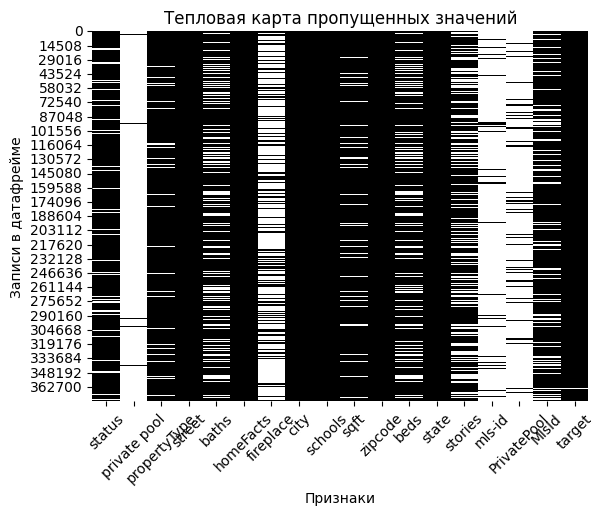

In [6]:
# Построим тепловую карту пропущенных значений в данных
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['black', 'white']),
    cbar = False
);
heatmap.set_title('Тепловая карта пропущенных значений');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в датафрейме');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

**Выводы по итогам знакомства с данными:**  
1. В данных содержится большое **количество пропусков</u>**:  
    1.1. Признак наличия бассейна, разделенный на два столбца "private pool" и "PrivatePool" содержит 99% и 89% пропусков соответственно. Можно предположить, что при объединении двух столбцов в один, процент пропусков не опустится ниже 70%, следовательно, от признака придется избавиться. Но сперва мы проверим нашу гипотезу.  
    1.2. Признак "fireplace" - 73% пустых значений. В случае острой нехватки данных для обучения модели, можно будет попытаться найти какие-то тренды по наличию камина в различных типах недвижимости и различных штатах (с применением признака "zipcode"), но пока для упрощения, избавимся от него.  
    1.3. Признак системы мультилистинга "msl-id" содержит 93% пропусков, тогда как его дубль "MlsId" - лишь 18% и вполне вероятно, что при объединении количество пропусков станет приемлемым. Однако стоит обратить внимание на высокий процент уникальных значений - свыше 60%. И это объяснимо, ведь данный признак - это некий Id объекта в системе. Можно видеть, что в нем соединены город нахождения объекта, штат и почтовый индекс. Все эти данные присутствуют в отдельных признаках, а значит от этих двух мы можем смело избавиться.  
    1.4. Целевой признак "target" содержит менее 1% пустых значений (или 2 481 запись). Такие записи не позволят нам обучить модель, поэтому от них сразу можно избавиться.
2. Количество **полных дубликатов** невелико - 50. От них мы тоже сразу избавимся.  
3. Признаки с высоким процентом **уникальных значений - неинформативные данные**:  
    3.1. "street" - 89%. Как следует из названия, это улица, на которой находится объект недвижимости. Признак может быть интересен для цели отображения точки на карте, но с точки зрения предсказания едва ли пригодится. Распределение по штатам в этом смысле более информативно.  
    Этот признак примечателен тем, что содержит почти 40 тыс. одинаковых названий. Учитывая, что это не только улица, но и номер дома, то одинаковые названия указывают, как правило, на один и тот же объект, а значит являются дубликатами. Например, это может быть объявление о продаже дома в 2020 году, и о продаже участка в 2018 году, когда дом еще не был построен. Или наоброт, когда дом снесли. А еще компания-застройщик может разместить несколько объявлений о продаже похожих домов по похожим ценам на одной улице и указать единый адрес для всех.  
    В эти 40 тыс. входят также и записи, где адрес не значится, например: "Undisclosed Address" или подобное. Таких объявлений - около 2 тыс.  
    Для целей предсказания неважно, входит ли один и тот же объект (в качестве земельного участка и в качестве дома) дважды в датафрейм, так как у них разные характеристики и разная цена в целевом признаке - модель выучит закономерности для того и другого типа. То же касается и массовой застройки и отсутствующих адресов: поскольку мы не планируем кодировать адреса, а будем опираться на другие признаки, то от дубликатов и пропущенных значений в признаке "street" мы избавимся вместе с самим признаком, как только необходимость в нем пропадет.   
    3.2. "homeFacts - 85%. Из этого признака попробуем выделить сведения об объектах: год постройки и реконструкции, начичие отопления и кондиционирования, парковки, размер участка и стоимости за квадратный фут. Поэтому его не будем пока удалять. Займемся им в разделе EDA.  
    3.3. "schools" - 79%. Из этого признака тоже в разделе EDA выделим информацию о школах, соседствующих с объектом недвижимости и лишь затем удалим.  
4. Прочие признаки:  
    4.1. "city" содержит 2009 уникальных названий городов. Среди них есть, конечно, написанные в верхнем регистре, которые можно объединить с обычным написанием, но все же количество довольно велико, а ценность невысока. В разных городах одного штата (с одинаковым климатом) цены, скорее всего, будут схожи. Явные отличия могут быть заметны разве что при сравнении крупных, знаменитых городов (Нью-Йорк, Лос-Анжелес, Майами) и/или столиц штатов. В связи с этим в данном разделе мы лишь избавимся от пустых значений (коих немного), а в разделе EDA выделим признак "столица штата".  
    4.2. "zipcode" - то же касается и признака почтового индекса: слишком много уникальных значений, однако этот признак пригодится нам при обработке признака "city", после чего мы удалим его.  

___

## 3. Предобработка и очистка данных (Data preparation)  

Начнем мы с намеченных в результате знакомства с данными шагов.  
Затем предобработаем каждый из признаков в отдельности. 

In [7]:
# Действия по результатам первичного анализа
print('Размерность датафрейма до предобработки:', df.shape)
rows = df.shape[0]
cols = df.shape[1]

df.drop(['mls-id', 'MlsId', 'fireplace'], axis=1, inplace=True) # удаляем ненужные признаки
df.dropna(axis=0, subset='target', inplace=True) # удаляем строки с пропусками в целевом признаке
df.dropna(axis=0, subset='city', inplace=True) # удаляем строки с пропусками в признаке города
df.drop_duplicates(inplace=True) # удаляем полные дубликаты

print('Размерность датафрейма после предобработки:', df.shape)
print(f'Удалены {rows-df.shape[0]} строки и {cols-df.shape[1]} столбца')

Размерность датафрейма до предобработки: (377185, 18)
Размерность датафрейма после предобработки: (374532, 15)
Удалены 2653 строки и 3 столбца


### 3.1. Обработка признака "status"  

In [8]:
# Выделим основные категории, которые имеют долю свыше 1%
status = df['status'].value_counts(normalize=True)*100
display('Доли типов собственности в датафрейме (%):', round(status[status > 1],2))

'Доли типов собственности в датафрейме (%):'

for sale            46.54
Active              31.35
For sale            12.96
foreclosure          1.69
New construction     1.63
Pending              1.40
Name: status, dtype: float64

Итак, две главные группы жилья по статусу - это: "Active" и "For Sale". Скорее всего, суть их одинакова, поэтому мы объединим их.    

В пятерку также вошли: "Foreclosure" - продажа недвижимости, вернувшейся к кредитору из-за неуплаты ипотеки (отличается от традиционной продажи, сюда же отнесем статус - "Auction"); "New construction" (также обозначается просто как "New") и "Pending" - все возможные случаи, в которых оформление сделки началось, но приостановилось (сюда же отнесем все вариации статуса "Contingency").

К жилью со статусом "New" присовокупим жилье со статусом "Coming soon <дата сдачи>", которое еще не сдано, но уже продается.  

Записи с жильем под аренду "Rent" (в количестве 412) мы удалим, потому что целевой признак для такого жилья указан за месяц и не поможет нам в предсказании.    

Таким образом, список групп будет следующим:  
- Active,  
- Foreclosure,  
- Pending,
- New.  

Причем начнем мы формирование групп с малочисленных, поскольку их ключевые слова часто стоит в паре с более значительными, например: "Active - Auction". Для того, чтобы в данном примере отнести такую недвижимость к статусу "Foreclosure", необходимо начать с поиска слова "Auction", а не "Active".  

Всем остальным статустам, а также пустым значениям статуса присвоим категорию "Other".  

Для решения задачи создадим функцию.  

In [9]:
# Функция объединения похожих по сути значений в признаке
def find_fill(fill_value: str,
              find_value: list,
              feature: str,
              df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция объединяет в одну группу fill_value похожие по сути
    значения find_value в признаке feature. Функция получает эти
    данные на вход вместе с датафреймом, затем отыскивает каждое
    значение в признаке и сохраняет индексы с таким значением,
    а затем заменяет их все на одно общее название. И возвращает
    обновленный датафрейм.

    Args:
        fill_value (str): общее название группы
        find_value (list): похожие по сути значение для объединения
        feature (str): названия признака, где происходит поиск
        df (pd.DataFrame, optional): датафрейм, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    # Создаем множество для хранения индексов строк
    ind = set()
    # Запускаем цикл по всем значениям признака, которые нужно найти в ячейках
    for value in find_value:
        # Добавляем ко множеству индексы всех строк с искомым значением value
        ind.update(df[df[feature].str.contains(value, case=False) == True].index)
    # Заменяем все значения по найденным индексам на общее значение
    df.loc[list(ind), feature] = fill_value

    del ind # очищаем память

    # Возвращаем обновленный датафрейм
    return df


In [10]:
# Создадим словарь из часто встречающихся cтатусов продажи;
# в качестве значений укажем типы для группировки
status_type = {
    'Foreclosure': ['auction', 'foreclo'],
    'Pending': ['continge', 'pend'],
    'New': ['new', 'coming'],
    'Active': ['active', 'sale']
}

# Организуем цикл по всем элементам словаря статусов продажи.
# В написанную фукцию будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам датафрейм
for s in status_type.items():
    df = find_fill(*s, 'status', df)

# Добавим к статусу Pending некоторые записи вручную. Они зашифрованы
# одной или несколькими буквами, поэтому требуют применения метода fullmatch
# Создаем список для хранения индексов строк
ind = []
ind.extend(list(df[df['status'].str.fullmatch('C') == True].index))
ind.extend(list(df[df['status'].str.fullmatch('P') == True].index))
ind.extend(list(df[df['status'].str.fullmatch(r'P[s,f,i]') == True].index))
df.loc[ind, 'status'] = 'Pending'

# Удалем объявления со статусом аренды
ind = df[df['status'].str.contains('rent', case=False) == True].index
df.drop(ind, axis=0, inplace=True)

# Всем оставшимся категориям жилья присвоим статус Other
mask = df['status'].isin(status_type.keys()) # сформируем маску из 4-х основных статусов
df.loc[df[~mask].index, 'status'] = 'Other' # всем остальным статусам присвоим Other

del status_type, ind, mask # удалим переменные

### 3.2. Обработка признака "private pool"  

Как мы видели на этапе знакомсnва с данными, в датафрейме присутсвуют два дублирующих друг друга признака с одинаковым названием, но разным написанием. Предположим, что значения в этих признаках дополняют друг друга. Проверим, сколько останется пропусков, если объединить эти два признака.  

In [11]:
# Создадим фильтры по пустым значениям и выведем результат анализа
mask1 = df['private pool'].isna() == True
mask2 = df['PrivatePool'].isna() == True
share = round(df[mask1 & mask2].shape[0] / df.shape[0] * 100, 2)
print(f'Доля пустых значений о бассейнах: {share}%')

del mask1, mask2, share

Доля пустых значений о бассейнах: 88.19%


Даже после объединения, доля пропущенных значений приближается к 90%. Придется избавиться от этого признака.

In [12]:
# Удаляем эти неинформативные признаки
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

### 3.3. Обработка признака "stories", этап 1  

Мы разбили обработку признака с количеством этажей на два этапа и первый этап поставили до обработки признака "propertyType" в связи с тем, что в последнем иногда содержится количество этажей, которое отсутствует в признаке "stories". Поэтому целью первого этапа является перенести информацию о количестве этажей из "propertyType" в "stories".  

На втором этапе мы займемся обработкой значений, которые будут находиться в признаке "stories", включая пустые.  

In [13]:
# Функция для выделения числа этажей
def story_num(s: str) -> str:
    """Функция принимает на вход строку и выделяет из нее
    количество этажей. Возвращает это количество или NaN,
    если оно не было в строке.

    Функция возвращает число этажей в формате строки, т.к.
    часто встречаются буквенные обозначения: "One Story".

    Например (исх. строка -> результат работы функции):
    - '1 Story' -> '1'
    - 'Detached, Two Story' -> 'Two'
    - 'Low-Rise (1-3 Stories)' -> '3'
    - 'Historical -> NaN

    Args:
        s (str): строка с количеством этажей из признака propertyType

    Returns:
        str: количество этажей в формате строки
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\w+)\+*\s[Sstor]', s) # выделяем число этажей
        if len(result) > 0:
            result = result[0] # если этаж был во входной строке, сохраняем его в формате строки
        else:
            result = np.NaN # если этажа не было, вернем NaN

    # Возвращаем результат в виде строки или float, если это NaN
    return result

In [14]:
# Сохраняем часть датафрейма, где вместо типа жилья указаны этажи (7.7+ тыс. объектов)
df_story = df[df['propertyType'].str.contains('stor', case=False) == True]
# Из этой таблицы выбираем те, у которых пустой признак stories, сохраняем индексы (7.6+ тыс.)
story_ind = df_story[df_story['stories'].isna() == True].index
# В главном датафрейме по сохраненному индексу заполняем пропуски в признаке stories
# Используем для этого написанную функцию
df.loc[story_ind, 'stories'] = df.loc[story_ind, 'propertyType'].apply(lambda s: story_num(s))

del df_story, story_ind # удаляем ненужные переменные

Кроме числа этажей в признаке "propertyType" также иногда содержится указание на размер объекта недвижимости: Low Rise (жилье от 1 до 3 этажей в высоту), Mid Rise (4-7 этажей), High Rise (от 8 этажей и выше). Воспользуемся этим для заполнения пропущенных значений в признаке "stories". Для этого напишем функцию, которую применим для каждой разновидности объектов.

In [15]:
# Функция для заполнения пустых значений в признаке на основе другого признака
def find_fillna(source_feature: str,
                target_feature: str,
                find_value: str,
                fill_value: str,
                df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция получает на вход название признака source_feature,
    в котором требуется искать find_value, затем в признаке
    target_feature отыскивает пустые значения и заполняет их
    с помощью fill_value. Все изменения производятся в переданном
    в функцию датафрейме, который и возвращается обновленным.

    Args:
        source_feature (str): признак, где производится поиск значения find_value
        target_feature (str): признак, где заполняются пустые значения
        find_value (str): значение для поиска в source_feature
        fill_value (str): значение для заполнения пропусков в target_feature
        df (pd.DataFrame, optional): датафрейм, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    #  Сохраняем часть датафрейма, где в признаке source_feature указано find_value
    df_story = df[df[source_feature].str.contains(find_value, case=False) == True]
    # Из этой таблицы выбираем те строки, в которых пустой признак target_feature
    story_ind = df_story[df_story[target_feature].isna() == True].index
    # В главном датафрейме заполняем пропуски в признаке target_feature на значение fill_value
    df.loc[story_ind, target_feature] = fill_value

    del df_story, story_ind # освобождаем память

    # Возвращаем обновленный датафрейм
    return df

In [16]:
# Применим написанную выше функцию для каждого из трех видов высоты объекта
df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Low.Rise',
    fill_value = 'Low Rise (1-3 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Mid.Rise',
    fill_value = 'Mid Rise (4-7 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'High.Rise',
    fill_value = 'High Rise (8+ Stories)',
    df = df
)

### 3.4. Обработка признака "propertyType"  

Несмотря на обилие типов жилья, выделим несколько главных, тем более, как мы убедились на этапе знакомства с данными, больше половины представляют собой отдельно стоящие дома для одной семьи ("Single family"). К этому типу отнесем все возможные архитектурные направления: "Cape Cod", "Colonial", "Farmhouse" и прочие. Нам важен лишь факт отдельно стоящего жилища для одной семьи. Разбиение на стили будет актуальным, если обученная модель будет показывать неудовлетворительные результаты предсказания цены, и нам нужно будет сгенерировать больше данных для обучения.  

По аналогии выделим жилье для нескольких семей ("Multifamily"): это может быть как отдельно стоящий дом, так и часть в комплексе "Townhouse".  

По аналогии в отдельную категорию вынесем "Townhouse" - дома для одной семьи, которые одной стеной примыкают к другому дому. Они дешевле и распространены в городах, где застройка плотнее. Очевидно, близость соседей означает меньший комфорт и, следовательно, может влиять на цену.  

Наконец, перейдем к квартирам - "Condo". Их насчитывается свыше 51 тыс. в датафрейме. Похожим по типу считается жилье "Apartment", которое якобы можно только снимать, но не купить, однако в нашей базе для таких квартир цены указаны именно на покупку, а не за аренду. К тому же, их насчитывается всего 813, поэтому для упрощения объединим их с типом "Condo". И сюда добавим также квартиры в жилищных кооперативах, промаркированных "Coop".

И еще одной группой станут пустые участки земли, которые имеют тип "lot / land". Обозначим их "Land".  

Все остальные объекты, которые не войдут в перечисленные 5 групп типов недвижимости, мы договоримся отнести к самому популярному типу - "Single famile" (хотя в датафрейме встречаются и гаражные постройки).  

Используем написанную в подразделе 3.1 функцию find_fill(), которая поможет нам отыскивать типы жилья и заменять их на название группы. После ее применения остатки вручную отнесем к первой группе.  


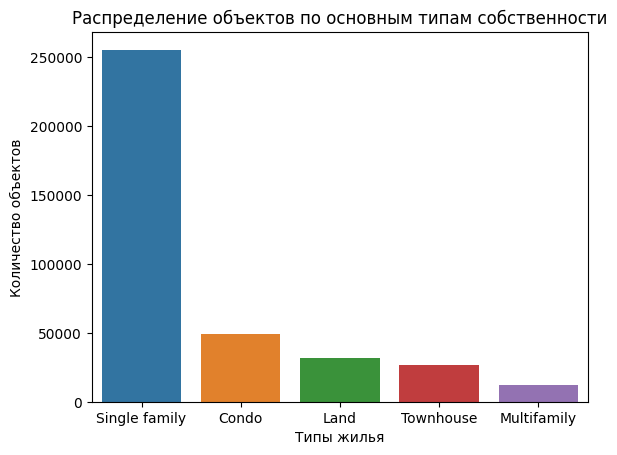

In [17]:
# Создадим словарь из часто встречающихся и хорошо разделяемых по смыслу
# типов недвижимости; в качестве значений укажем типы для группировки
proper_type = {
    'Single family': ['single', 'bunga', 'cluster', 'colon', 'cape',
                      'contemp', 'cottage', 'craft', 'farm', 'federal',
                      'french', 'feder', 'florida', 'garden', 'historic',
                      'mediter', 'mobile', 'other', 'ranch', 'spanish',
                      'split', 'tradit', 'transit', 'tudor', 'victor',
                      'Low.Rise', '1 Sto', 'One Sto', '2 Sto', 'Two Sto'],
    'Multifamily': ['multi'],
    'Townhouse': ['town', 'co-op'],
    'Condo': ['condo', 'apart', 'coop', 'Mid.Rise', 'High.Rise'],
    'Land': ['land', 'lot']
}

# Организуем цикл по всем элементам словаря типов недвижимости
# В фукцию find_fill() будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам датафрейм
for p in proper_type.items():
    df = find_fill(*p, 'propertyType', df)

# Оставшиеся малочисленные типы недвижимости заменим на Single family
# Для этого сначала сохраним ключи словаря в список
main_types = list(proper_type.keys())

# Создадим маски по основным типам объектов
mask1 = df['propertyType'] == main_types[0]
mask2 = df['propertyType'] == main_types[1]
mask3 = df['propertyType'] == main_types[2]
mask4 = df['propertyType'] == main_types[3]
mask5 = df['propertyType'] == main_types[4]

# Выберем индексы записей из датафрейма, которые не относятся к 5 типам
left_ind = df[~mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5].index

# Присвоим им всем (36,4 тыс.) самый популярный тип - Single family
df.loc[left_ind, 'propertyType'] = main_types[0]

# Проверим, что все типы недвижимости рассортированы по пяти группам
# и посмотрим на их соотношения
barplot = sns.barplot(
    data = df['propertyType'].value_counts().to_frame().reset_index(),
    y = 'propertyType',
    x = 'index'
);
barplot.set_title('Распределение объектов по основным типам собственности');
barplot.set_xlabel('Типы жилья');
barplot.set_ylabel('Количество объектов');

### 3.5. Обработка признака "stories", этап 2  

На предыдущем этапе нам удалось выделить информацию о количестве этажей и тем самым уменьшить долю пропусков в этом признаке с 40% до 37%. Теперь заполним пропуски с помощью данных, которые мы сохранили в признак "propertyType". Число этажей также разделим на группы для простоты по следующему принципу:  
- Single family - Low Rise (1-3 Stories),  
- Multifamily - Low Rise (1-3 Stories),  
- Townhouse - Low Rise (1-3 Stories),  
- Condo - Low Rise (1-3 Stories), Mid Rise (4-7 Stories), High Rise (8+ Stories),  
- Land - 0 Stories.  

Итак, только квартиры могут располагаться в широком диапазоне этажей. Возможно, это оказывает влияние на цену, поэтому нам жетально сохранить такое разделение у квартир. Поэтому мы сначала отдельно обработаем все записи для типа недвижимости "Condo". При этом, если в датафрейме есть указание на этаж квартиры, мы его сохраним, отнеся к соответствющей категории. Если же ячейка пустая, то присвоим наиболее часто встречающуюся этажную категорию - это Low Rise: с 1 по 3 этажи.  

После работы с квартирами всем остальным типам объектов присвоим выбранные категории вне зависимости от того, что хранится в ячейках признака "stories".  

In [18]:
# Проверим, что доля пустых значений уменьшилась с 40%
print('Оставшаяся доля пустых значений в признаке stories {:2.2%}'\
      .format(df['stories'].isna().sum() / df.shape[0]))

Оставшаяся доля пустых значений в признаке stories 37.32%


In [19]:
# Составим список категорий этажей
story_list = ['Low Rise (1-3 Stories)', 'Mid Rise (4-7 Stories)',
              'High Rise (8+ Stories)', '0 Stories']

# Обновим ранее созданый словаь, присвоив типам недвижимости
# наиболее рапространенную категорию этажей для этой недвижимости
for t in main_types:
    if t == 'Land':
        proper_type[t] = story_list[3] # для Land - 0 Stories
    else:
        proper_type[t] = story_list[0] # для остальных - Low Rise

In [20]:
# Функция обработки этажей для типа недвижимости Condo
def convert_condo_story(s: object) -> str:
    """Функция получает на вход значение ячейки признака stories и
    обрабатывает его:
    - если в ячейке содержится строка с числом, то функция преобразовывает
    его к типу float и проводит сравнение с тремя этажными сегментами
    и возвращает название одного из сегментов (для пустого значения NaN
    присваивается наиболее распространенное - Low Rise);
    - если в ячейке содержится строка с текстом и при обрабоке возникает
    ошибка, функция перехватывает ее и работает далее с текстом:
    она проверяет, есть ли в строке указание на этажный сегмент, и если
    есть, то возвращает его, а если нет, то возвращает Low Rise.

    Args:
        s (object): значение ячейки: float для NaN или строка

    Returns:
        str: строка с одним из трех этажных сегментов
    """

    try: # если в ячейке - только число, то преобразуем его во float
        if 0 <= float(s) <=3:
            result = story_list[0] # для этажей с 0 по 3 - Low Rise
        elif 4 <= float(s) <=7:
            result = story_list[1] # для этажей с 4 по 7 - Mid Rise
        elif 8 <= float(s):
            result = story_list[2] # для этажей свыше 7 - High Rise
        else:
            result = story_list[0] # для NaN присвоим Low Rise
    except: # если в ячейке - текст, то сохраним существующие этажи
        if s.find('Low') != -1:
            result = story_list[0] # для Low Rise
        elif s.find('Mid') != -1:
            result = story_list[1] # для Mid Rise
        elif s.find('High') != -1:
            result = story_list[2] # для High Rise
        else:
            result = story_list[0] # или присвоим распространенный Low Rise

    # Возвращаем результат
    return result

In [21]:
# Отфильтруем датафрейм по типу недвижимости - Condo
ind = df[df['propertyType'] == 'Condo'].index
# С помощью написанной функции преобразуем значения
df.loc[ind, 'stories'] = df.loc[ind, 'stories'].apply(lambda x: convert_condo_story(x))
# Убедимся, что все значения подпадают под одну из трех категорий
display('Категории этажей для квартир:', df.loc[ind, 'stories'].value_counts())

'Категории этажей для квартир:'

Low Rise (1-3 Stories)    38505
High Rise (8+ Stories)     7271
Mid Rise (4-7 Stories)     3294
Name: stories, dtype: int64

Пустых значений в признаке stories:  0


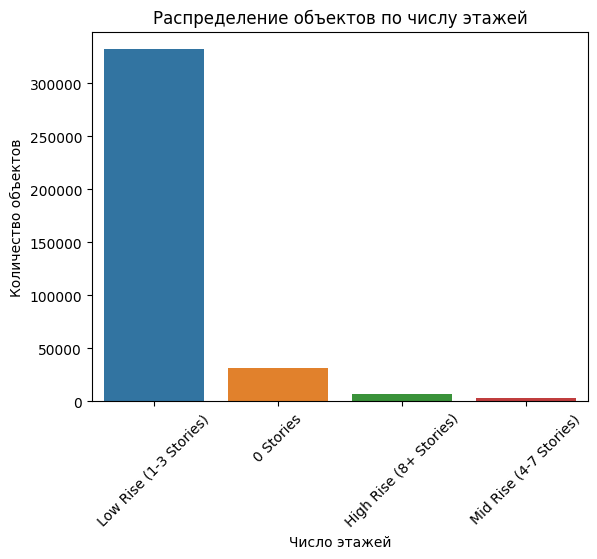

In [22]:
# Теперь заполним значения для всех остальных типов недвижимости
for p in proper_type:
    if p == 'Condo': # если тип недвижимости - квартира, ...
        continue     # пропускаем его, т.к. он уже обработан
    # Отфильтруем датафрейм по типу недвижимости
    ind = df[df['propertyType'] == p].index
    # Присвоим категорию этажности всем объектам данного типа
    df.loc[ind, 'stories'] = proper_type[p]

# Убедимся, что пустых значений в признаке не осталось
print('Пустых значений в признаке stories: ', df['stories'].isna().sum())

# Посмотрим на распределение объектов в зависимости от числа этажей
barplot = sns.barplot(
    data = df['stories'].value_counts().to_frame().reset_index(),
    y = 'stories',
    x = 'index'
);
barplot.set_title('Распределение объектов по числу этажей');
barplot.set_xlabel('Число этажей');
barplot.set_ylabel('Количество объектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

del ind # очистим память

### 3.6. Обработка признака "baths"  

Выделим из ячейки типа object количество ванных комнат и сохраним его в формате float. Формат с плавающей точкой продиктован самими данными в датафрейме. Часто встречаются дробные значения ванных комнат, например: 3.5, 1.75. Возможно, это ошибка. А, возможно, способ закодировать не полноценную ванную комнату с раковиной и большой ванной, а, скажем, комнату с раковиной и душевой кабиной или раковиной и туалетом - гостевой туалет. (Наше предположение позже подтвердилось материалом по [ссылке](https://therealtyfirms.com/half-bath-quarter-bath-three-quarter-bath/).)  

Вместе с тем, присутствуют и явно аномальные значения, которые превышают тысячи. Поскольку они имеют в остальных разрядах нули, можем предположить, что это опечатка, и нули отбросить. Например: 3500.00 примем за 3.5 ванных комнаты.

Итак, напишем функцию преобразования и применим ее к столбцу "baths".  

In [23]:
# Напишем функцию для выделения числа ванных из строки
def bath_num(b: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество ванных комнат в формате float.
    Возвращает это количество или NaN, если оно не было в строке.

    Функция возвращает float без округления, т.к. дробные значения
    могут означать не полные ванные комнаты, а, например, ванную
    с душевой кабиной, или только туалет.

    Например (исх. строка -> результат работы функции):
    - '4 ba' -> 4.0
    - '3.5 Baths' -> 3.5
    - '1,500' -> 1500
    - NaN -> NaN
    - '~' -> NaN

    Args:
        b (str): строка с количеством ванных комнат

    Returns:
        float: количество ванных комнат или NaN
    """

    if b is np.NaN:
        result = np.NaN # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'\d+\.*,*\d*', b) # выделяем число ванных
        if len(result) > 0:
            result = result[0] # если оно содержалось в строке, оно - на 1-м месте списка
            result = float(result.replace(',', '')) # убираем запятую-разделитель тысяч и приводим к float
            if result >= 1000: # устраняем опечатку
                result = result / 1000
        else:
            result = np.NaN # если в строке не было числа комнтат, сохраним NaN

    return result

# Применяем написанную функцию и преобразуем признак baths
df['baths'] = df['baths'].apply(lambda b: bath_num(b))

Мы сохранили в формате float количество ванных комнат и справились с тем, что посчитали опечатками (3500 ванных вместо 3.5), но заметили также явные аномалии, когда количество ванных комнат исчисляется десятками. Посмотрим на диаграмме, как обстоят дела с выбросами.  

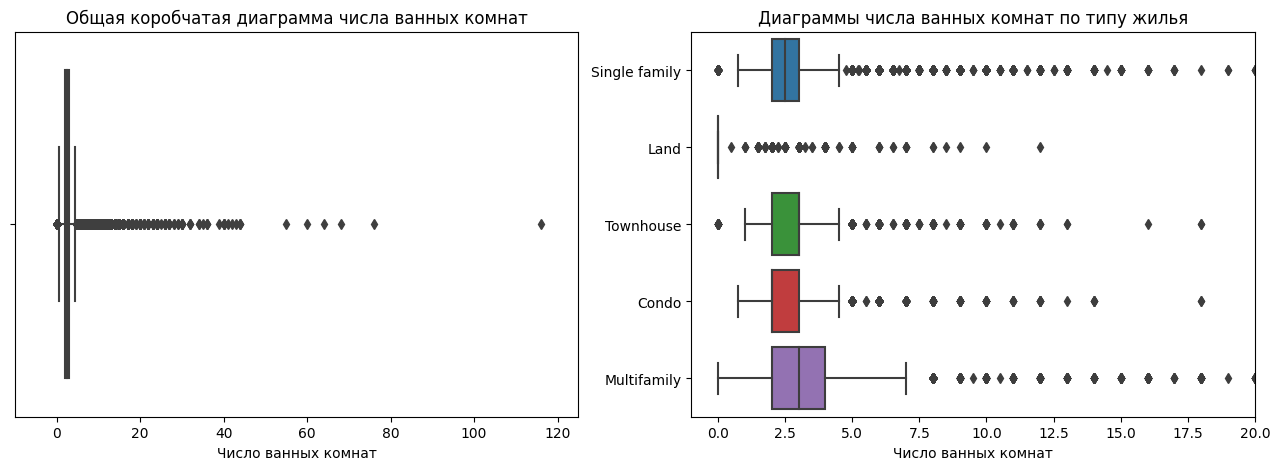

In [24]:
# Построим две коробчатые диаграммы признака baths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Общую диаграмму признака
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    ax = axes[0]
);
boxplot.set(xlim=(-10,125)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Общая коробчатая диаграмма числа ванных комнат');
boxplot.set_xlabel('Число ванных комнат');

# И диаграмму с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    y = 'propertyType',
    ax = axes[1]
);
boxplot.set(xlim=(-1,20)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Диаграммы числа ванных комнат по типу жилья');
boxplot.set_xlabel('Число ванных комнат');
boxplot.set_ylabel('');

Скорее всего, в доме для одной семьи количество ванных не превышает 1-3 единиц. В многосемейных домах, вероятно, это количество можно умножить на число семей. В этом смысле левая диаграмма для всего признака малоинформативна, поэтому посмотрим на правую, где диаграмма разбита по типу жилья. Можно заметить, что медиана для каждого типа находится в диапазоне 2-3 (за исключением земельного участка Land, где нет построек и не может быть ванных комнат).  

Попробуем определить выбросы методом Тьюки и для этого сначала проверим, распределены ли наши данные нормально. Воспользуемся тестом Шапиро-Уилка.  


In [25]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака ванных комнат
_, p = shapiro(df['baths'])
print('Результаты теста Шапиро-Уилка:')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

Результаты теста Шапиро-Уилка:
p = 1.000
Данные распределены нормально


По результатам теста мы можем воспользоваться методом Тьюки и выявить выбросы в количестве ванных комнат. Воспользуемся для этого написанной функцией.  

In [26]:
# Функция определения выбросов по методу Тьюки
def outliers_iqr(data: pd.DataFrame,
                 feature: str) -> tuple:
    """Функция определяет выбросы по методу Тьюки. Для этого она
    получает на вход датафрейм с выбросами и название признака,
    а возвращает кортеж из двух датафреймов: выбросы и очищенные
    данные.

    Args:
        data (pd.DataFrame): датафрейм с выбросами
        feature (str): название признака для очистки

    Returns:
        tuple: кортеж из датафреймов (выбросы и очищенные данные)
    """
    # Вычисляем квартили и межквартильное расстояние
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    # Определяем границы диапазона
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)

    # Определяем выбросы и очищенные записи
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]

    # Возвращем результат в виде кортежа датафреймов
    return outliers, cleaned

In [27]:
# Применим написанную функцию и выведем результаты ее работы на экран
outliers, cleaned = outliers_iqr(df, 'baths')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном датафрейме: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству ванных комнат среди выбросов:',
    outliers['baths'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 23498
Результирующее число записей: 242406
Процент выбросов в исходном датафрейме: 6.28%


'ТОП-5 по количеству ванных комнат среди выбросов:'

5.0    9435
6.0    4290
0.0    3911
7.0    2072
8.0    1158
Name: baths, dtype: int64

Итак, метод Тьюки посчитал выбросами объекты недвижимости, где количество ванных комнат равно или свыше 5. Также к выбросам он отнес и нулевое значение ванных. Возможно, причиной этому служит то, что данные все же не распределены нормально: в датафрейме большое количество аномальных значений свыше 10-20, а вот ниже нуля количество не опускается.  

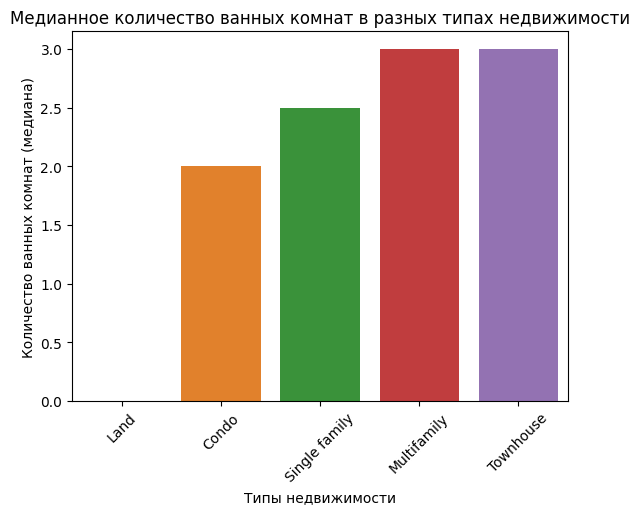

In [28]:
# Вычислим медианное значение ванных комнат для разных типов недвижимости
proper_bath_med = df.groupby('propertyType')['baths'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bath_med.to_frame().reset_index(),
    y = 'baths',
    x = 'propertyType'
);
barplot.set_title('Медианное количество ванных комнат в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество ванных комнат (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

К пропускам можно отнести нулевое количество ванных комнат в домах. Посмотрим на их количество.  

In [29]:
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

'Нулевое количество ванных комнат в различных типах жилья:'

propertyType
Land             3707
Multifamily        32
Single family     148
Townhouse          24
Name: baths, dtype: int64

Для типа недвижимости Land отсутствие ванной - это нормально, и отклонением будет считаться число, отличное от нуля. Об этом свидетельствует и медиана.  

Поэтому заполним одновременно пропуски, а также заменим нулевые значения на медианы по типу недвижимости.  

(В цикле ниже нулевые значения для Land будут заменяться на нулевую же медиану для Land. Это сделано намеренно для простоты цикла.)  

In [30]:
# Запускаем цикл по всем типам недвижимости
for p in proper_bath_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['baths'].isna() == True # маска по пропускам в baths
    mask3 = df['baths'] == 0 # маска по нулевым значениям
    ind = df[mask1 & (mask2 | mask3)]['baths'].index # сохраняем индекс
    df.loc[ind, 'baths'] = proper_bath_med[p] # приcваиваем медиану

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке baths:', df['baths'].isna().sum())
# Проверяем, что нулевое количество ванных осталось только в Land
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

del mask1, mask2, mask3, ind, proper_bath_med # очистим память

Осталось пропусков в признаке baths: 0


'Нулевое количество ванных комнат в различных типах жилья:'

propertyType
Land    30777
Name: baths, dtype: int64

Нам остается только поправить значения, которые выбиваются из принятой концепции обозначения ванных с помощью четвертей, например: 1.1, 3.2.    

Таких во всем датафрейме - не больше 100, и десятичная часть не превышает 2. Поэтому просто отбросим все после точки.  

In [31]:
ind = df[df['baths'] % 0.25 != 0]['baths'].index
df.loc[ind, 'baths'] = df.loc[ind, 'baths'].round()
print(f'Произведено {len(ind)} замен')

Произведено 80 замен


### 3.7. Обработка признака "city"

Данный признак нам пригодится в разделе EDA при проектировании других признаков, поэтому обработаем его:  
- заменим пустые строки, а также значения "other" на названия городов (для этого воспользуемся признаком почтового кода "zipcode"),
- разделим написание "city" с именем города (например, "commercecity"),   
- заменим распространенные сокращения на полные назания ("pt" -> "port"),  
- заменим редко встречающиеся в датафрейме названия городов на более распространенные ("e. new york" -> "brooklyn").  

В признаке содержится чуть больше 2000 уникальных значений, однако и среди них встречаются повторения из-за ошибок в написании, сокращений или разного регистра. Поэтому первым шагом приведем все названия к нижнему регистру.  



In [32]:
# Приводим к нижему регистру
df['city'] = df['city'].str.lower()

#### Обработка пустых названий и other  

In [33]:
# Создадим датафрейм для подбора подходящего названия города по индексу
zip_city_df = df.groupby(['zipcode', 'city'])['city'].count()

# Отберем все города, где вместо названия содержится слово other
ind = []
ind.extend(df[df['city'].str.contains('other') == True].index)
ind.extend(df[df['city'] == ' '].index)
print('Исправлено записей, где вместо названий городов либо other, либо два пробела:',
      len(ind))

# Заменим на наиболее подходящее название города
df.loc[ind, 'city']\
= df.loc[ind, ['zipcode']]\
.applymap(lambda x: zip_city_df[x].sort_values(ascending=False).index[0]).squeeze()

# Для записей, для которых не удалось подобрать название города по индексу,
# оставим other, чтобы не терять данные для обучения
ind = df[df['city'].str.contains('other') == True].index
print(f'Не удалось заменить other в {len(ind)} записях.')
df.loc[ind, 'city'] = 'other'

Исправлено записей, где вместо названий городов либо other, либо два пробела: 78
Не удалось заменить other в 3 записях.


#### Обработка слитного написания city

In [34]:
# Отберем все города, где слово city написано слитно
ind = df[df['city'].str.contains(r'\wcity') == True].index
print('Исправлено записей, где city написано слитно:', len(ind))

# Заменим на наиболее подходящее название города
p = re.compile('(\w+)city') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: p.findall(x)[0] + ' city').squeeze()


Исправлено записей, где city написано слитно: 67


#### Обработка сокращений

- [X] st -> saint  
- [X] pt -> port  
- [X] ft -> fort  
- [X] mt -> mount  
- [X] twp -> township

In [35]:
# Отберем все города, где вначале написано st или st.
ind = df[df['city'].str.match('(st\.*)\s+') == True].index
print('Исправлено записей с сокращениями st/st.:', len(ind))

# Заменим на наиболее подходящее название города
p = re.compile('(st\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'saint ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями st/st.: 1666


In [36]:
# Отберем все города, где есть сокращение pt/pt.
ind = df[df['city'].str.match('(pt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями pt/pt.:', len(ind))

# Заменим на развернутое port
p = re.compile('(pt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'port ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями pt/pt.: 243


In [37]:
# Отберем все города, где есть сокращение ft/ft.
ind = df[df['city'].str.match('(ft\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями ft/ft.:', len(ind))

# Заменим на развернутое fort
p = re.compile('(ft\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'fort ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями ft/ft.: 32


In [38]:
# Отберем все города, где есть сокращение mt/mt.
ind = df[df['city'].str.match('(mt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями mt/mt.:', len(ind))

# Заменим на развернутое mount
p = re.compile('(mt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'mount ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями mt/mt.: 4


In [39]:
# Отберем все города, где есть сокращение twp/twp.
ind = df[df['city'].str.contains('\s+(twp\.?)', case=False) == True].index
print('Исправлено записей с сокращениями twp/twp.:', len(ind))

# Заменим на развернутое township
p = re.compile('\s+(twp\.?)') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: x[:p.search(x).start()] + ' township').squeeze()

Исправлено записей с сокращениями twp/twp.: 50


#### Обработка остальных редко встречающихся названий  

In [40]:
# Заменим сокращенные/редкие названия городов на полные
df.loc[df[df['city'] == 'new york city'].index, 'city'] = 'new york'
df.loc[df[df['city'] == 'e. new york'].index, 'city'] = 'brooklyn'
df.loc[df[df['city'] == 'point charlotte'].index, 'city'] = 'port charlotte'
df.loc[df[df['city'] == 'p c beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'west panama city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'piney pt village'].index, 'city'] = 'piney point village'
df.loc[df[df['city'] == 'city center'].index, 'city'] = 'las vegas'
df.loc[df[df['city'] == 'pete beach'].index, 'city'] = 'saint pete beach'
df.loc[df[df['city'] == 'atlaanta'].index, 'city'] = 'atlanta'
df.loc[df[df['city'] == 'n miami beach'].index, 'city'] = 'miami beach'

# Выведем результат работы
print('Осталось уникальных значений городов:', df['city'].nunique())

# Удаляем ненужные более признак индекса и очищаем память
df.drop('zipcode', axis=1, inplace=True)
del zip_city_df, ind, p

Осталось уникальных значений городов: 1866


Итак, нам удалось сократить количество уникальных названий. Конечно, можно было применить мощные библиотеки для работы с текстом и провести более глубокое исследование с использованием актуальных баз названий городов США для сравнения или с подключением к API Multiple Listing Service для сопоставления по идентификатору "MlsId".

Для целей нашего проекта, выполненной предобработки данного признака будет достаточно. И мы удалили ненужный более признак "zipcode".  

### 3.8. Обработка признака "sqft"  

На данном этапе мы превратим признак в числовой, но не будем удалять пустые значения (хоть их чуть больше 10%). Дело в том, что с помощью признака цены за квадратный фут, который мы создадим в разделе EDA, мы сможем восстановить некоторые пропущенные значения.  


In [41]:
# Функция для выделения площади жилья
def sqft_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество квадратных футов. Возвращает это количество или NaN,
    если оно не было в строке.

    Args:
        s (str): строка с количеством квадратных футов из признака sqft

    Returns:
        float: количество квадратных футов
    """

    if (s is np.NaN) or (s is None):
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\d+)', s) # выделяем квадратные футы
        if len(result) > 0:
            result = result[0] # если они найдены, сохраняем их
        else:
            result = np.NaN # если не найдены, вернем NaN

    # Возвращаем результат в виде float
    return result

In [42]:
# Сперва избавимся от запятых, отделяющих иногда тысячные разряды
df['sqft'] = df['sqft'].str.replace(',', '')

# Затем воспользуемся написанной функцией, чтобы выделить квадратные футы
df['sqft'] = df['sqft'].apply(sqft_num).astype(float)

# Заменяем нулевые значения на пропуски
ind = df[df['sqft'] == 0].index
df.loc[ind, 'sqft'] = np.NaN
del ind

### 3.9. Обработка признака "beds"  

Этот признак содержит количество спальных комнат либо в виде цифры/числа, либо в формате "`n` Beds/bd", где `n` - число спален. Все остальные записи либо пустые, либо не содержат нужно информации, например, встречаются записи, в которых вместо спальных комнат записана площадь в квадратных футах или акрах. При этом она всегда превышает значения в признаке "sqft", так что, вероятно, является площадью самого участка, а не недвижимости, а значит не имеет для нас значения.  

Таким образом, несмотря на то, что количество пропущенных значений (np.NaN), как мы зафиксировали на этапе знакомства с данными, равняется 90825 (или 24% от датафрейма), вместе с неинформативными записями превышает 109 тыс. (или 29%). Будем считать, что порог 30% не превышен и заменим пустые значения (которыми мы обозначим в том числе неактуальные записи).  

Но сначала избавимся от выбросов.  

In [43]:
# Функция для выделения числа спален в признаке
def beds_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество спальных комнат. Возвращает это количество или NaN,
    если оно не было найдено в строке.

    Например (исх. строка -> результат работы функции):
    - '3 Beds' -> 3
    - '10 beds' -> 10
    - '3 bd' -> 3
    - '11 bd' -> 11
    - '15.0 bd' -> 15
    - '-- bd' -> nan
    - '8' -> 8
    - '8.0' -> 8
    - '12' -> 12
    - '12.0' -> 12
    - '10 bath' -> nan
    - 'Bed 14' -> nan

    Args:
        s (str): строка с количеством спален

    Returns:
        float: количество спален
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    elif s.isdigit():
        result = s # если в строке только число спален без точки, оставляем строку
    else:
        result = re.findall(r'(\d+)\s+[Bb]ed', s) # выделяем число спален из формата 10 Beds
        if len(result) > 0:
            result = result[0]
        else:
            result = re.findall(r'(\d+)\.*\d*\s+bd', s) # выделяем число спален из формата 3.0 bd
            if len(result) > 0:
                result = result[0]
            else:
                result = re.findall(r'(\d+)\.', s) # выделяем число спален из формата 10.0
                if len(result) > 0:
                    result = result[0]
                else:
                    result = np.NaN # если спален нет, а только текст, то - np.NaN

    # Возвращаем число спален в формате float
    return float(result)

# Применяем написанную функцию для выделения числа спален
df['beds'] = df['beds'].apply(beds_num)

# Проверяем долю пустых значений
print('Доля пустых значений в признаке beds: {:2.2%}'.format(df['beds'].isna().sum()/df.shape[0]))

Доля пустых значений в признаке beds: 29.27%


Проверим, что данные распределены нормально, и воспользуемся методом Тьюки, чтобы выявить выбросы в данных.

In [44]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака спальных комнат
_, p = shapiro(df['beds'])
print('Результаты теста Шапиро-Уилка:')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

Результаты теста Шапиро-Уилка:
p = 1.000
Данные распределены нормально


In [45]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'beds')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном датафрейме: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству спален среди выбросов:',
    outliers['beds'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 19836
Результирующее число записей: 244796
Процент выбросов в исходном датафрейме: 5.30%


'ТОП-5 по количеству спален среди выбросов:'

6.0    6547
1.0    6396
0.0    2278
7.0    1828
8.0    1214
Name: beds, dtype: int64

Метод Тьюки отнес к выбросам ноль спален и одну спальню, а также свыше 5. Как мы увидим чуть ниже, когда рассчитаем медианы, это вполне обоснованно.  

Однако применим логику. Как правило, число спален находится в некоей зависимости от числа ванных комнат (или наоборот). Наше предположение выше состояло в том, что число ванных комнат редко превышает число спален. Проверим это, вычислив отношение и взяв медиану.   

In [46]:
print('Отношение числа спален к числу ванных:', (df.beds / df.baths).median())

Отношение числа спален к числу ванных: 1.25


Таким образом, наше предположение подтвердилось. Имея обработанный признак "baths" мы можем не просто заменять пропуски и нули на медиану, но и сверяться с вычисленным значением "beds".  

Нижнюю границу выбросов опустим до 0: спальни отсутствуют на пустых участках земли (как правило, а также в строениях, не являющихся домами, но отнесенными нами к группе "Sigle family"), и 1 спальня вполне может быть в недорогом односемейном доме.  

Определим верхнюю границу выбросов. Посколько для ванных мы ограничили данные чилом 7, следовательно спален в таком случае может быть: `7 * 1.25 = 8.75`. Округлим до 9. Тогда будем считать выбросами все записи, в которых число спален превышает 9.  

Проверим их число, удалим и посчитаем медиану для каждого типа недвижимости.  

In [47]:
# Проверим количество объектов, у которых спален больше 9
beds_9_plus = df[df['beds'] > 9].index
print(f'Свыше 9 спален насчитывается в {len(beds_9_plus)} объектах')
print('Это составляет лишь {:2.2%} всего датафрейма'.format(len(beds_9_plus)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(beds_9_plus, axis=0, inplace=True)
del beds_9_plus

Свыше 9 спален насчитывается в 1082 объектах
Это составляет лишь 0.29% всего датафрейма


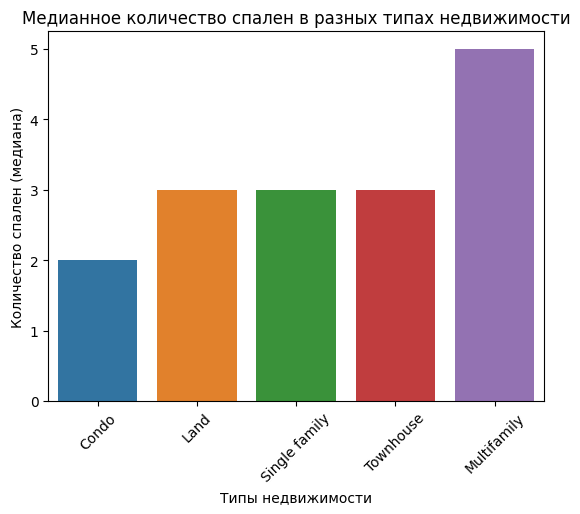

In [48]:
# Вычислим медианное значение спален для разных типов недвижимости
proper_bed_med = df.groupby('propertyType')['beds'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bed_med.to_frame().reset_index(),
    y = 'beds',
    x = 'propertyType'
);
barplot.set_title('Медианное количество спален в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество спален (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

Далее будем действовать следующим образом:  
1) сгруппируем данные по типу недвижимости,  
2) вычислим коэффициент отношения спален к ванным для каждого типа недвижимости (он может несколько отличаться от общего 1.25),  
3) в качестве замены пустому значению или нулю используем наибольшее из двух: медиану или число ванных, умноженное на вычисленный коэффициент.  

In [49]:
# Запускаем цикл по всем типам недвижимости
for p in proper_bed_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['beds'].isna() == True # маска по пропускам в beds
    mask3 = df['beds'] == 0 # маска по нулям в beds
    ind = df[mask1 & (mask2 | mask3)]['beds'].index # сохраняем индекс
    coef = (df[mask1].beds / df[mask1].baths).median() # вычисляем коэффициент
    # Присваиваем или медиану, или число ванных*коэф. - что больше
    # (причем важно сравнивать именно в таком порядке, чтобы не получить nan)
    df.loc[ind, 'beds'] = df.loc[ind, 'beds']\
                          .apply(lambda x: max(proper_bed_med[p], x*coef))

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке beds:', df['beds'].isna().sum())
# Проверяем, что нулевое количество спален не осталось ни в одном типе жилья
display('Нулевое количество спален в различных типах жилья:',
        df[df['beds'] == 0].groupby('propertyType')['beds'].count())

del mask1, mask2, mask3, ind, coef, proper_bed_med # очистим память

Осталось пропусков в признаке beds: 0


'Нулевое количество спален в различных типах жилья:'

Series([], Name: beds, dtype: int64)

### 3.10. Обработка признака "state"  

Необходимость обработки этого признака возникла на этапе EDA, однако, действуя в парадигме CRISP-DM, мы перенесли манипуляции над признаком в раздел предобработки в целях сохранения прозрачности и последовательности процесса.  

В признаке обнаружились несуществующие аббревиатуры штатов. Соберем их в таблицу с количеством записей и способом устранения ошибки.

| Ошибка | Записей | Устранение |  
|---|---:|---|  
| Fl | 1 | Заменить на FL |  
| DC | 4513 | Заменить на WA |  
| BA | 1 | Удалить |  
| OS | 1 | Удалить |  
| OT | 1 | Удалить |  

In [50]:
# Заменим неверные аббревиатуры шатов
df.loc[df[df['state'] == 'Fl'].index, 'state'] = 'FL'
df.loc[df[df['state'] == 'DC'].index, 'state'] = 'WA'

# По остальным сохраним индекс и удалим записи по индексам
ind = []
ind.extend(df[df['state'] == 'BA'].index)
ind.extend(df[df['state'] == 'OS'].index)
ind.extend(df[df['state'] == 'OT'].index)
df.drop(ind, axis=0, inplace=True)

del ind # очистим память

### 3.11. Обработка признака "target"  

Целевой признак стоимости объекта недвижимости содержит сумму в долларах США. Сперва очистим его от пропусков, символа валюты, разделителя разрядов (запятой) и знака плюс в конце и приведем к типу `int`.  

Далее проверим на наличие выбросов. При этом снова сгруппируем данные по типу жилья.  

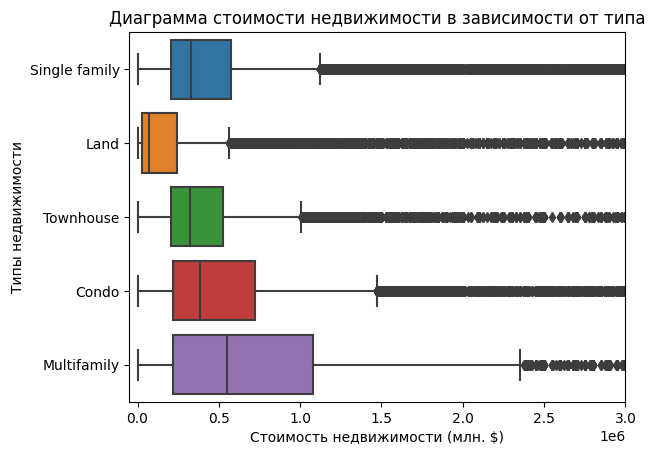

In [51]:
# Очищаем признак target
df['target'] = df['target'].str.replace('$', '', regex=False)
df['target'] = df['target'].str.replace(',', '', regex=False)
df['target'] = df['target'].str.replace('+', '', regex=False).astype(int)

# Построим диаграмму целевого признака с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'target',
    y = 'propertyType'
);
boxplot.set(xlim=(-50000,3000000)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма стоимости недвижимости в зависимости от типа');
boxplot.set_xlabel('Стоимость недвижимости (млн. $)');
boxplot.set_ylabel('Типы недвижимости');

Как можно судить по диаграмме, распределение стоимости недвижимости в любой из групп далеко от нормального (тест Шапиро-Уилка это подтвержает), поэтому воспользоваться методом Тьюки мы не можем.  

Попробуем пролагорифмировать признак.  

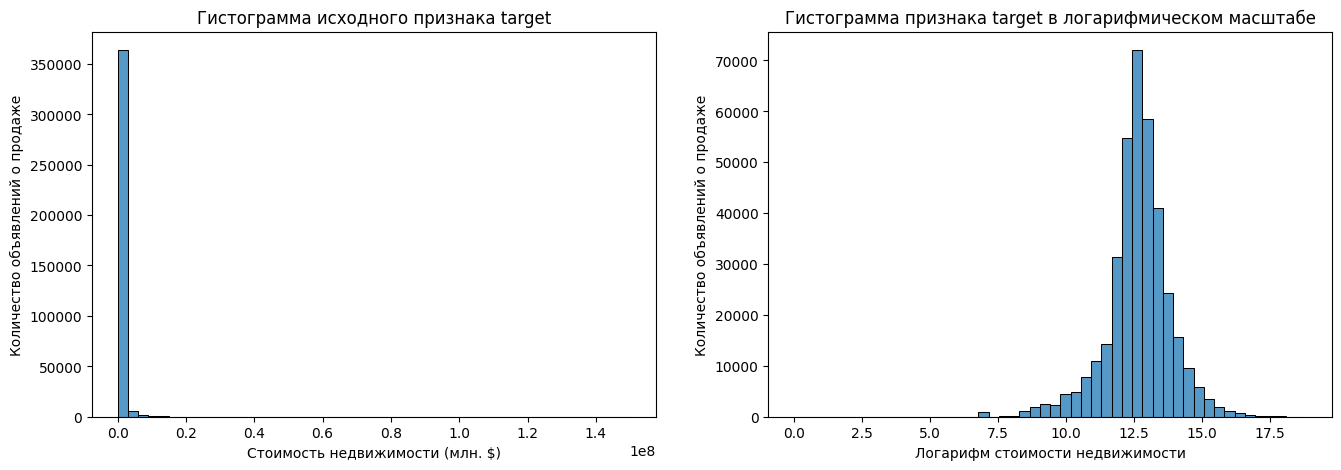

In [52]:
# Построим две гистограммы признака target: без логарифмирования и с таковым
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Гистограмма исходного признака
histplot = sns.histplot(
    data = df['target'],
    bins = 50,
    ax = axes[0]
);
histplot.set_title('Гистограмма исходного признака target');
histplot.set_xlabel('Стоимость недвижимости (млн. $)');
histplot.set_ylabel('Количество объявлений о продаже');

# Гистограмма признака в логарифмическом масштабе
log_target = np.log(df['target']) # min(target) > 0, поэтому смело берем log
histplot = sns.histplot(
    data = log_target,
    bins=50,
    ax=axes[1]
);
histplot.set_title('Гистограмма признака target в логарифмическом масштабе');
histplot.set_xlabel('Логарифм стоимости недвижимости');
histplot.set_ylabel('Количество объявлений о продаже');

Итак, благодаря логарифмированию нам удалось привести распределение признака практически к нормальному.  

Для выявления выбросов воспользуемся методом z-отклонений (трех сигм). При этом в первых итерациях мы отходили от распространенных трех стандартных отклонений (в сторону их увеличения) ввиду того, что объекты с максимальной стоимостью в нашем датафрейме (свыше 100 млн. $) действительно существуют - это огромные земли и дорогие дома, которые можно увидеть на Google Maps по адресу из признака street; мы также расширяли левую границу, поскольку наблюдали большое количество недорогих объектов недвижимости разных типов.  

Однако на этапе прогнозирования столкнулись в низким значением целевой метрики, в результате чего нам пришлось ужесточить критерии определения выбросов и в итоге даже сузить границы отклонений с 3 до 2.  

Напишем функцию для определения выбросов, которая пригодится нам еще в разделе EDA. Затем построим гистрограммы, на которых отобразим границы выбросов для каждого их типа недвижмости.  

In [53]:
# Функция определения выбросов по методу z-отклонений (трех сигм)
def outliers_z_score(df: pd.DataFrame,
                     feature: str,
                     log_scale: bool = True,
                     left: int = 3,
                     right: int = 3) -> tuple:
    """Функция определяет выбросы среди наблюдений по методу
    z-отклонения, или трех сигм (количество сигм регулируется
    в вызывающем операторе).

    Args:
        df (pd.DataFrame): исходный датафрейм
        feature (str): признак, в котором определяем выбросы
        log_scale (bool): переход к лог. масштабу, по умолчанию = True
        left (int): кол-во сигм для нижней границы, по умолчанию = 3
        right (int): кол-во сигм для верхней границы, по умолчанию = 3

    Returns:
        tuple (pd.DataFrame): датафреймы с выбросами и очищенный
    """

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feature].min() > 0: # если значения признака больше 0
            x = np.log(df[feature])
        else:
            x = np.log(df[feature]+1) # иначе добавляем единицу
    else:
        x = df[feature]

    # Вычисляем мат.ожидание и стандарт. отклонение
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    # Определяем выбросы и очищенные данные
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]

    # Возвращаем кортеж из pd.DataFrame
    return outliers, cleaned

In [54]:
# Создадим списки типов недвижимости ...
property_list = list(df['propertyType'].unique())
# и границ метода z-отклонений для них
boundaries = [(2,2), (2,2), (2,2), (2,2), (2,2)] # первоначальные границы были 3+
# Объединим их в словарь
prop_bound = dict(zip(property_list, boundaries))
# Подготовим список названий цветов для гистограмм
hist_colors = ['blue', 'orange', 'green', 'red', 'purple']

# Добавим признак выброса в датафрейм и установим нули
df['outliers'] = 0

# В цикле вычислим выбросы для каждого типа недвижимости
for i, p_type in enumerate(prop_bound):
    # Определяем выборосы с помощью написанной функции
    outliers, cleaned = outliers_z_score(df = df[df['propertyType'] == p_type],
                                         feature = 'target',
                                         log_scale = True,
                                         left = prop_bound[p_type][0],
                                         right = prop_bound[p_type][1])

    print(f'Число выбросов по методу z-отклонений для {p_type}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {p_type}: {cleaned.shape[0]}\n')
    # Установим флаг выброса в признаке
    df.loc[outliers.index, 'outliers'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {df.outliers.sum()} выбросов.')

Число выбросов по методу z-отклонений для Single family: 14389
Результирующее число записей для Single family: 240401

Число выбросов по методу z-отклонений для Land: 987
Результирующее число записей для Land: 30336

Число выбросов по методу z-отклонений для Townhouse: 1274
Результирующее число записей для Townhouse: 25070

Число выбросов по методу z-отклонений для Condo: 2355
Результирующее число записей для Condo: 46695

Число выбросов по методу z-отклонений для Multifamily: 539
Результирующее число записей для Multifamily: 10989

Всего по методу z-отклонений выявлено 19544 выбросов.


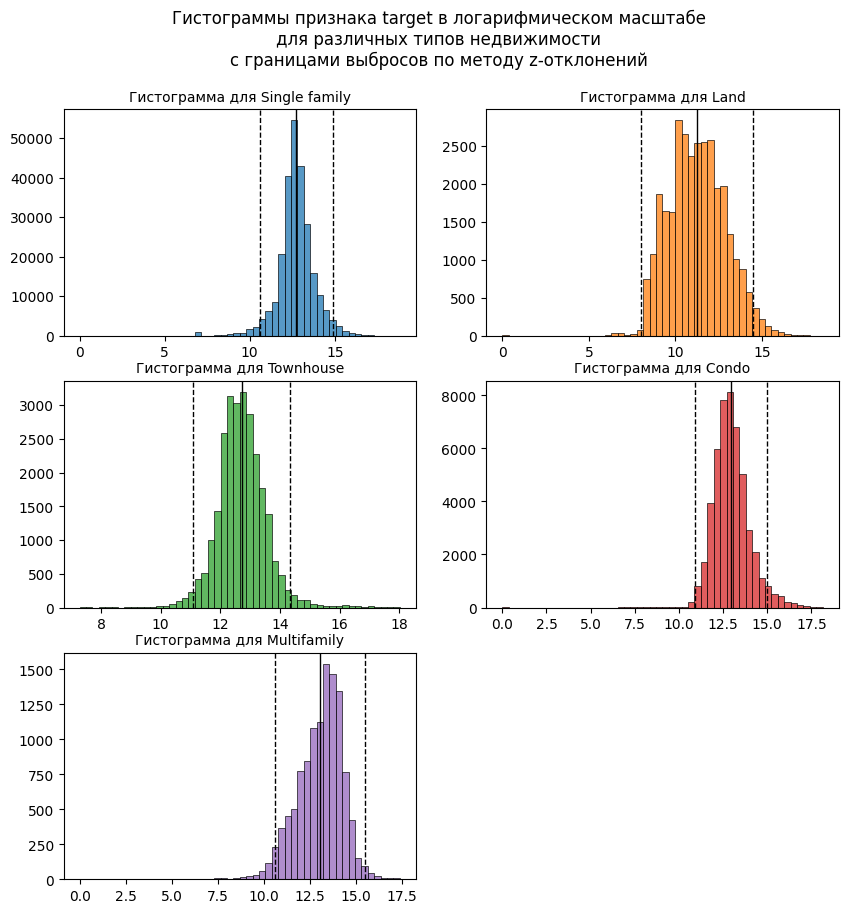

In [55]:
# Следом построим гистограммы для каждого типа с границами выбросов
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Гистограммы признака target в логарифмическом масштабе\n'+\
             'для различных типов недвижимости\n'+\
             'с границами выбросов по методу z-отклонений', fontsize=12);

# Снова воспользуемся циклом
for i, p_type in enumerate(prop_bound):
    # Переводим признак в логарифмическую шкалу
    if df[df['propertyType'] == p_type]['target'].min() > 0:
        log_target = np.log(df[df['propertyType'] == p_type]['target'])
    else:
        log_target = np.log(df[df['propertyType'] == p_type]['target']+1)

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + prop_bound[p_type][1] * log_target.std()
    lower_bound = log_target.mean() - prop_bound[p_type][0] * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = 50,
        ax = axes[divmod(i, 2)],
        color = 'tab:' + hist_colors[i]
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {p_type}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');
fig.delaxes(axes[2, 1]); # удалим неиспользуемое поле

Глядя на гистограммы, можем отметить, что меньше похожи на нормальные распределения типы недвижимости Land и Multifamily.  

"Ненормальность" гистограммы для земельных участков связана, скорее всего, с их различными размерами.  
В группе многосемейных домов наблюдается левосторонняя ассиметрия из-за большого числа домов по цене ниже моды. Наиболее популярный ценовой сегмент представлен на нашей гистограмме тремя столбиками, начиная с моды, вслед за которыми число объектов резко падает.  

На всех гистограммах можно видить длинные хвосты и даже аномальные всплески вдали от центра. Все эти записи вносили большую ошибку в прогноз, поэтому мы так сильно сузили границы отклонений (до 2).

Итак, мы отобрали почти 19,5 тыс. выбросов и пометили их специальным флагом в признаке "outliers". В разделе EDA мы попробуем в первую очередь скоректировать стоимости этих объектов с помощью десериализованного признака цены за квадратный фут. Если это не поможет, то окончательно удалим их из датафрейма.  

Перед дальнейшей обработкой датафрейма взглянем на распределение стоимости объектов по штатам.  


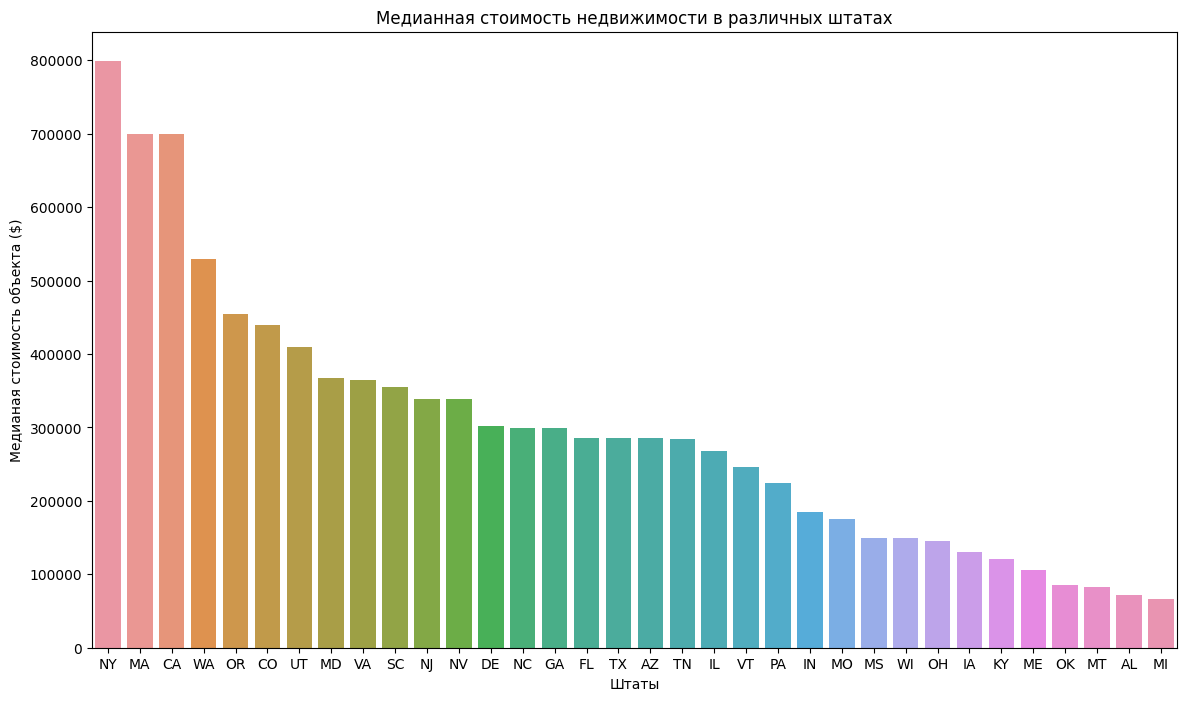

In [56]:
# Сгруппируем объекты по штатам и посчитаем медиану
state_target_gr = df.groupby('state')['target'].median()
state_target_gr = state_target_gr.to_frame(name='median').reset_index()
state_target_gr = state_target_gr.sort_values(by='median', ascending=False)

# Построим график зависимости стоимости от штата
fig = plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    state_target_gr,
    x = 'state',
    y = 'median'
);
barplot.set_title('Медианная стоимость недвижимости в различных штатах');
barplot.set_xlabel('Штаты');
barplot.set_ylabel('Медианая стоимость объекта ($)');

Самая дорогая недвижимость в штате Нью-Йорк. Затем идут Массачуссетц и Калифорния.

Самые дешевые объекты можно купить к Мичигане, Алабаме и Монтане.  

Распределение довольно яркое, в отличие от, скажем, принадлежности объектов недвижимости городам. Без построение графика скажем, что на нем стоимость изменяется плавно (при сортировке).  

Это подтверждает наши основания в разделе EDA при обработке признаков отопления и кондиционирования группировать объекты именно по штатам, а не по городам.  

Интересно было бы взглянуть также на зависимость стоимости объекта от его площади. Но мы сделаем это после удаления выбросов в признаках "sqft" и "target" в разделе EDA, потому сейчас диаграмма будет совершенно неинформативна.  

А сейчас перейдем к baseline-решению.  
___

## 4. Базовое решение задачи предсказания (Baseline modeling)  

Итак, предобработка и очистка данных завершена - мы готовы построить baseline-решение. С этой целью мы используем два алгоритма:  
- простую модель обратной регресии, чтобы на ее примере увидеть результат дальнейшей обработки данных в разделе EDA,  
- модель CatBoostRegressor с параметрами по умолчанию, чтобы продемонстрировать довольно высокий результат лишь после предварительной обработки данных.  

Перед обучением моделей отбросим необработанные признаки "street", "homeFacts", "city" и "schools" и закодируем оставшиеся категориальные. Избавимся также от пропущенных значений в признаке "sqft". Их доля составляет 11%, так что это не должно значительно повлиять на результаты.  

Для оценки качества моделирования на протяжении всего проекта мы будем использовать три метрики качества:  
- `MAE` - среднюю абсолютную ошибку, чтобы понимать, на сколько тысяч долларов ошиблась модель,
- `MAPE` - среднюю абсолютную ошибку в процентах поскольку стоимость жилья - вещь относительная,    
- `R2` - коэффициент детерминации, чтобы понимать, насколько хорошо модель улавливает закономерности - целевая метрика.   

In [57]:
# Избавимся от текстовых признаков
df_baseline = df.drop(['street', 'homeFacts', 'city', 'schools'], axis=1)
# Избавимся от пропущенных значений
df_baseline = df_baseline.dropna()

# Избавимся от выбросов, найденных при обработке "target"
ind = df_baseline[df_baseline['outliers'] == 1].index
df_baseline = df_baseline.drop(ind, axis=0)
del ind

# Отобразим кол-во уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df_baseline.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status           5
propertyType     5
state           33
stories          4
dtype: int64

Таким образом, для признака "state" используем Binary Encoder (поскольку число уникальных значений выше 15), а для остальных - OneHot Enoder.

In [58]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df_baseline[oh_cols])
# Присоединяем к датафрейму закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df_baseline[['state']])
# Присоединяем к датафрейму закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
df_baseline = df_baseline.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося датафрейма:', df_baseline.shape)

Размер получившегося датафрейма: (307335, 25)


In [59]:
# Подготовим выборки
X = df_baseline.drop('target', axis=1)
y = df_baseline['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(215134, 24) (92201, 24) (215134,) (92201,)


In [60]:
# Функция для расчета метрик и вывода на экран
def show_metrics(y_train: pd.Series,
                 y_train_pred: pd.Series,
                 y_test: pd.Series,
                 y_test_pred: pd.Series,
                 precision: int = 2,
                 show: bool = True) -> tuple:
    """Функция выводит на экран значения метрик MAE, MAPE и R2
    с заданной точностью, а также возвращает их.

    Args:
        y_train (pd.Series): тренировочный вектор ответов
        y_train_pred (pd.Series): тренировочный предсказанный вектор
        y_test (pd.Series): тестовый вектор ответов
        y_test_pred (pd.Series): тестовый предсказанный вектор
        precision (int): точность округления, по умолчанию = 2
        show (bool): флаг вывода на экран, по умолчанию = True

    Returns:
        tuple (float): кортеж из 6 метрик на случай необходимости
    """

    # Вычислим метрики и выведем их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    r2_test = r2_score(y_test, y_test_pred)

    if show: # если флаг вывода на экран установлен
        print('MAE на тренировочоной выборке:', round(mae_train, precision))
        print('MAPE на тренировочной выборке:', round(mape_train, precision))
        print('r2 на тренировочоной выборке:', round(r2_train,2))

        print('\nMAE на тестовой выборке:', round(mae_test, precision))
        print('MAPE на тестовой выборке:', round(mape_test, precision))
        print('r2 на тестовой выборке:', round(r2_test,2))

    # Вернем вычисленные метрики
    return mae_train, mape_train, r2_train, mae_test, mape_test, r2_test

In [61]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# И выведем результаты
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 278492.61
MAPE на тренировочной выборке: 97.56
r2 на тренировочоной выборке: 0.12

MAE на тестовой выборке: 277717.83
MAPE на тестовой выборке: 97.28
r2 на тестовой выборке: 0.13


In [62]:
# Обучим модель CatBoostRegressor
# Подготовим выборки в формате класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Создаем модель с параметрами по умолчанию
model = CatBoostRegressor(random_state = 42,
                          verbose = False)

# Обучаем модель
model.fit(train_pool)

# Делаем предсказание
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 172501.11
MAPE на тренировочной выборке: 51.01
r2 на тренировочоной выборке: 0.61

MAE на тестовой выборке: 174610.16
MAPE на тестовой выборке: 51.96
r2 на тестовой выборке: 0.59


In [63]:
# Очистим память
del df_baseline, X, y, X_train, X_test, y_train, y_test,\
    train_pool, test_pool, model, y_train_pred, y_test_pred

> **Выводы по baseline-решению:**  
>
> 1. Простая модель линейной регресии показала крайне неудовлетворительные результаты: ошибка в 250 тыс., или 84% и коеффициент детерминации = 0.25 (наилучшее значение, напомним, = 1). Это означает, что модель не уловила закономерностей в данных. Тем не менее, позже мы увидим, насколько большое значение играет качественная обработка данных и EDA, когда увидим улучшение показателей этой модели.  
>
> 2. Продвинутая модель CatBoostRegressor показала гораздо лучшие результаты даже на таких плохо обработанных данных: ошибка в 173 тыс. долларов, или 51% на тестовых данных, и R2 = 0.57 (хорошими считаются показания выше 0.5). Это говорит о качестве модели, способной с базовыми настройками улавливать связи в данных. Далее мы будем в том числе сравнивать наши показатели и с этой оценкой.  
>  
> А пока перейдем к анализу данных.  
>
___

## 5. Разведывательный анализ данных (Data Preparation - EDA)

В этом разделе мы займемся десериализацией признаков "homeFacts" и "schools", которые обогатят наш датафрейм и закончим обработку других признаков, которые мы частично очистили в разделе 3.  

Мы также выдвинем гипотезы о взаимосвязи признаков и подтвердим или опровергнем их с применением визуализации.  

### 5.1. Обработка признака "homeFacts"  

В этом признаке содержится сериализованный словарь данных об объекте недвижимости:  
- Year built - год постройки,  
- Remodeled year - год обновления,  
- Heating - вид отопления,  
- Cooling - вид охлаждения,  
- Parking - наличие парковки,  
- lotsize - размер участка,  
- Price/sqft - цена за квадратный фут.  

Напишем специальную функцию, которая будет предобрабатывать строку, находящуюся в ячейке, и десериализовывать ее, возвращая 7 перечисленных значений. Эти 7 значений будем записывать в 7 одноименных признаков в нашем датафрейме, которые для этого создадим. Обработкой сохраненных значений займемся на следующем шаге.  

In [64]:
# Функция десериализации строки со словарем значений
def deserialize_home(s: str) -> pd.Series:
    """Функция возвращат значения словаря, который находится
    в сериализованном виде в строке s.

    Args:
        s (str): строка с сериализованным словарем

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """

    # Десериализуем строку в словарь и сразу сохраним его единственое значение
    # json.loads() не подошел, т.к. в признаке неодинаковое использование
    # одинарных кавычек, поэтому используем eval()
    result = eval(s)['atAGlanceFacts']

    # В единственном значении словаря хранится список из 7 элементов,
    # каждый из которых представлен двумя словарями: factValue и factLabel
    # С помощью дополнения списка сохраним в список только factValue
    # и вернем их, а там уже присвоим 7-ми признакам
    return pd.Series([r['factValue'] for r in result])

In [65]:
# Воспользуемся написанной функций, чтобы создать новые признаки из homeFacts
df[['yearBuilt', 'remodeledYear', 'heating', 'cooling',
    'parking', 'lotsize', 'price_sqft']] = df['homeFacts'].apply(deserialize_home)

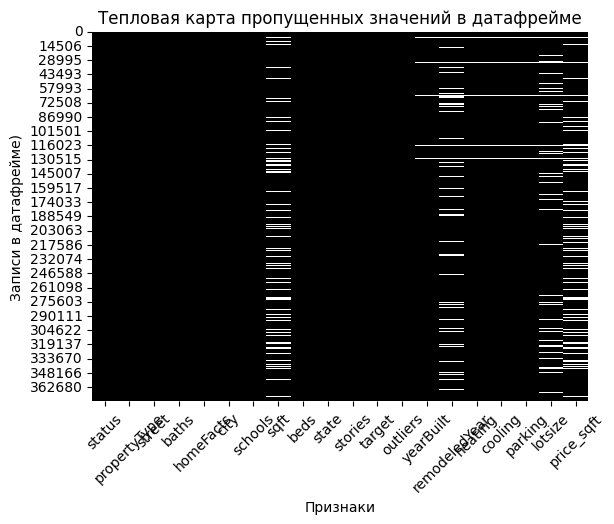

In [66]:
# Построим тепловую карту пропущенных значений в датафрейме
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['black', 'white']),
    cbar = False
);
heatmap.set_title('Тепловая карта пропущенных значений в датафрейме');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в датафрейме)');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

Видно, что и в десериализованных данных содержатся пропуски, а значит нам придется их обработать.

### 5.2. Обработка признаков "yearBuilt" и "remodeledYear"  

Вычислим возраст здания или участка. Для этого возьмем наибольшее из двух значений (год постройки или год обновления) и сравним с текущим годом (2023). Сперва, однако, придется объединить эти два признака, заполнить пустые значения.   

In [67]:
# Посчитаем пропущенные значения в новых признаках (NaN + пустые ячейки)
yb_na = df['yearBuilt'].isna().sum()
yb_na += df[df['yearBuilt'] == ''].shape[0]
yb_na_share = round(yb_na / df.shape[0] * 100, 2)

yr_na = df['remodeledYear'].isna().sum()
yr_na += df[df['remodeledYear'] == ''].shape[0]
yr_na_share = round(yr_na / df.shape[0] * 100, 2)

print(f'Количество пустых ячеек в yearBuilt - {yb_na}, что составляет {yb_na_share}%.')
print(f'Количество пустых ячеек в remodeledYear - {yr_na}, что составляет {yr_na_share}%.')

Количество пустых ячеек в yearBuilt - 61790, что составляет 16.56%.
Количество пустых ячеек в remodeledYear - 223407, что составляет 59.89%.


In [68]:
# Функция объединения признаков yearBuilt и remodeledYear
def year_compare(b, r):
    """Функция получает на вход значение года из двух ячеек,
    сравнивает их друг с другом и возвращает наибольшее из двух.
    Предусмотрена обработка значений типа None и np.NaN: если
    только одно из переданных значение имеет данный тип, то
    возвращается второе. Если же оба значения не содержат год,
    то возвращается None с целью последующего заполнения.

    Args:
        b (str | NoneType): значение признака yearBuilt
        r (str | NoneType): значение признака remodeledYear

    Returns:
        str | NoneType: наибольший год из двух, либо None
    """

    if (b == np.NaN) or (b == None) or (b == ''): # если в b нет года
        if (r is np.NaN) or (r == None) or (r == ''): # и в r нет года
            result = None # то вернем None
        elif r.isdigit(): # если же в r есть год
            result = r # то вернем r
        else:
            result = None # иначе вернем None (маловероятный сценарий)
    elif b.isdigit(): # если же в b есть год
        if (r == np.NaN) or (r == None) or (r == ''): # а в r нет года
            result = b # то вернем b
        elif r.isdigit(): # если же в r тоже есть год
            if int(b) >= int(r): # сравним, и, если b больше или равен r
                result = b # то вернем b
            else:
                result = r # иначе - r
        else:
            result = None # если r и не None, и не год, то вернем просто b
    else:
        result = None # если ни одно не год и не None, то вернем None (маловероятный сценарий)

    #Возвращаем результат работы функции (в виде строки)
    return result

# Создадим признак, объединяющий два с помощью функции выше
df['lastYear'] = df[['yearBuilt', 'remodeledYear']].apply(lambda x: year_compare(*x), axis=1)

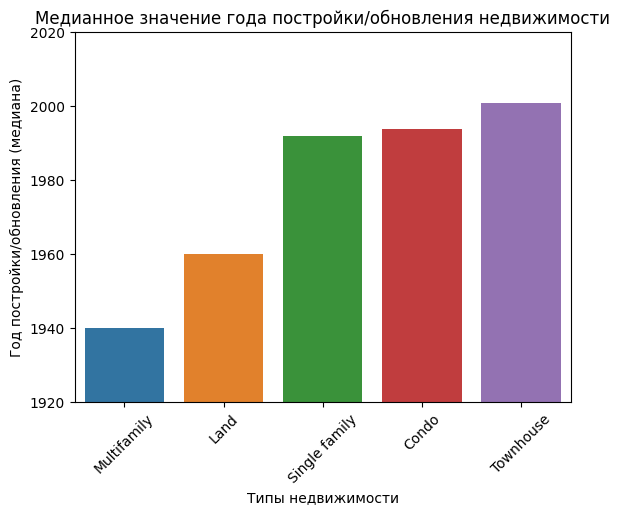

In [69]:
# Вычислим медианное значение года постройки или обновления для разных типов недвижимости
proper_year_med = df.groupby('propertyType')['lastYear'].median().sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_year_med.to_frame().reset_index(),
    y = 'lastYear',
    x = 'propertyType'
);
barplot.set_title('Медианное значение года постройки/обновления недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Год постройки/обновления (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.set(ylim=(1920,2020)); # ограничим диапазон по вертикали для наглядности

Судя по диаграмме, наиболее старыми (давно построенными и не обновлявшимися) являются многосемейные дома.

Далее, кажется, можно проследить эволюцию жилища: примерно одинаково развивались односемейные частные дома в небольших городах и пригородах и квартиры в крупных городах. А затем возникло некое слияние двух типов - таунхаус: примыкающие друг к другу односемейные дома, которые делят инфраструктуру, как квартиры. Вполне вероятно, что с таким развитием и связаны годы постройки и обновления соответствующих типов жилья, которые присутствуют в нашем датафрейме.

Как бы то ни было, используем эти медианные значения, чтобы заполнить пропуски в признаке, а затем создадим новый - "age", куда сохраним "возраст" жилья или участка.  

In [70]:
# Запускаем цикл по всем типам недвижимости и заполняем пропуски медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['lastYear'].isna() == True # маска по пропускам в lastYear
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Приводим к типу int, потому что даты как таковой в признаке нет
df['lastYear'] = df['lastYear'].astype(np.int64)

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке lastYear:', df['lastYear'].isna().sum())

Осталось пропусков в признаке lastYear: 0


Проверим, есть ли выбросы в получившемся признаке года постройки/обновления. Для этого построим коробчатую диаграмму.  

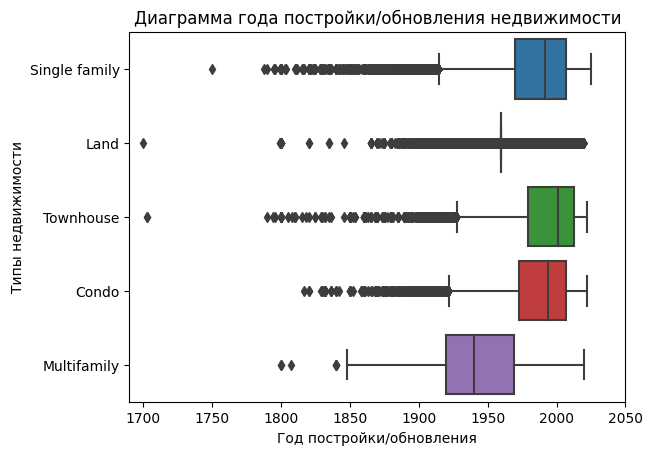

In [71]:
# Построим коробчатую диаграмму признака lastYear
boxplot = sns.boxplot(
    data = df,
    x = 'lastYear',
    y = 'propertyType'
);
boxplot.set(xlim=(1690,2050));
boxplot.set_title('Диаграмма года постройки/обновления недвижимости');
boxplot.set_xlabel('Год постройки/обновления');
boxplot.set_ylabel('Типы недвижимости');

Исходя из диаграммы, примем за выбросы все даты до 1700 года и после 2022 года. Заменим их на медианы.  
А следом сгенерируем новый признак возраста.  

In [72]:
# Запускаем цикл по всем типам недвижимости и заменяем выбросы медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = (df['lastYear'] < 1700) | (df['lastYear'] > 2022) # маска по выбросам
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Генерируем признак возраста
df['age'] = 2023 - df['lastYear']

# Удаляем ненужные более признаки
df.drop(['yearBuilt', 'remodeledYear', 'lastYear'], axis=1, inplace=True)

del proper_year_med, p, mask1, mask2, ind # и память очистим

### 5.3. Обработка признаков "heating", "cooling", "parking"  

Начнем с проверки пустых значений.  

In [73]:
# Создадим список из трех десериализованных признаков, с которыми будем работать одновременно
hcp_list = ['heating', 'cooling', 'parking']

# Проверим пропуски в них
for f in hcp_list:
  print(f'В признаке {f} найдено {df[f].isna().sum()} пропуска,\
  это {round(df[f].isna().sum()/df.shape[0]*100,2)}% датафрейма.')

В признаке heating найдено 3424 пропуска,  это 0.92% датафрейма.
В признаке cooling найдено 3424 пропуска,  это 0.92% датафрейма.
В признаке parking найдено 3424 пропуска,  это 0.92% датафрейма.


Может показаться, что пропусков мало. Однако детальное исследование этих признаков открыло, что в них содержится большое количество повторяющихся значений: пустых строк, нулей, значений 'No Data', значений типа NoneType.  

Отнести их все к категории пропущенных было бы неверно еще и потому, что их процент в датафрейме в таком случае сразу увеличится до 30-50%!  

В действительности мы имеем дело с удобствами в жилище: наличие/отсутствие отопления (любого вида), кондиционирования и парковки. В этой связи условимся так трактовать часто встречающиеся значения:  

- пропуск, отсутствие информации: NaN, None (как тип NoneType без кавычек), 'No Data',  
- отсутствие удобства в доме: ' '(пустая строка в кавычках), '0', 'None' (вручную вписанное значение в кавычках),  
- наличие удобства: все остальные разнообразные значения, не вошедшие в предыдущие две группы.  

Напишем функцию, которая реализует соответствующее преобразование и применим ее к трем признакам. А затем сразу перепроверим количество отсутствующих значений.  

In [74]:
# Функция для приведения всех значений признаков к трем категориям
def three_state_feat(s: str) -> str:
    """Функция получает на вход значение из признака и относит
    его к одной из трех категорий: пропуск, отсутствие
    удобства (отопления/кондиционирования/парковки) или
    его наличие. Возвращает одну из трех категорий в виде строки.

    Args:
        s (str | NoneType): значение признака (heating, cooling, parking)

    Returns:
        str: одна из трех категорий
    """

    if (s is None) or (s is np.NaN) or (s == 'No Data'):
        result = 'missing' # категория пропуска
    elif (s == '') or (s == 'None') or (s == '0'):
        result = 'No' # удобство отсутствует
    else:
        result = 'Yes' # иначе удобство есть в наличии

    # Возвращаем результат
    return result

# Применим написанную функцию к трем признакам
for f in hcp_list:
    df[f] = df[f].apply(three_state_feat)

# Проверим отсутствующие значения в признаках после обработки
for f in hcp_list:
  mis = df[df[f] == 'missing'].shape[0]
  print(f'В признаке {f} найдено {mis} отсутствующих значений,\
  это {round(mis/df.shape[0]*100,2)}% датафрейма.')

В признаке heating найдено 11815 отсутствующих значений,  это 3.17% датафрейма.
В признаке cooling найдено 13784 отсутствующих значений,  это 3.7% датафрейма.
В признаке parking найдено 16403 отсутствующих значений,  это 4.4% датафрейма.


Как видно, количество пропущенных значений подросло, но не сильно. Заполним их.  

Наличие и отсутствие отопления в домах распределились во всем датафрейме почти как 70/30. То же и с кондиционированием. А вот с парковками - практически 50/50. Как же быть?  

Логично предположить, что в домах, расположенных в теплых широтах отопление менее востребовано, чем кондиционирование. Севернее - наоборот. Тут разумно группировать записи по штатам.  

А вот парковочное место всегда есть в частном доме и очень редко в крупных городах. Следовательно для признака "parking" больше подошла бы группировка по названию города.  

Начнем с группировки по признаку "state" и проверим наши предположения. Причем для того, чтобы проследить связь с климатом, к нашим таблицам мы добавим скачанные из интернета среднегодовые температуры по штатам. И, чтобы упростить работу, будем пользоваться климатическим рейтингом штатов от самого жаркого до самого холодного.  

(Пояснения по парсингу данных о температуре: температура в градусах Фаренгейта и Цельсия, а также рейтинг штата по этим значениям хранятся в тегах \<td>, откуда мы их из заберем.  
Далее из полученного списка сформируем датафрейм, сохранив в его столбцы названия штатов, температуру в градусах Цельсия, а также рейтинг. Подобные образом будем действовать при формировании связующего датафрейма с названиями и аббревиатурами штатов.)    

Итак,  
1) парсим данные о температурах,  
2) объединяем с кросс-таблицами по признакам и иллюстрируем,  
3) выявляем закономерности.  

In [75]:
# Определяем адрес страницы с температурами в штатах и выполняем GET-запрос
url = 'https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с данными о температуре по штатам
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, F, C, рейтинг
temperatures = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов, средних температур и рейтинга
temp_df = pd.DataFrame(list(zip(temperatures[::4],
                                temperatures[2::4],
                                temperatures[3::4])),
                       columns = ['state_name', 'temp', 'rank'])
# Приведем рейтинг к типу int
temp_df['rank'] = temp_df['rank'].astype(int)


# Теперь проделаем то же самое с целью поиска связки "штат - аббревиатура"
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием и аббревиатурой штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура
states_abb = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов и их аббревиатур
abb_df = pd.DataFrame(list(zip(states_abb[0::2],states_abb[1::2])),
                       columns = ['state_name', 'state'])
# Удаляем лишние символы в начале каждой ячейки
abb_df['state_name'] = abb_df['state_name'].str.strip()
abb_df['state'] = abb_df['state'].str.strip()

# Объединяем два датафрейма
state_temp_df = pd.merge(
    abb_df,
    temp_df,
    on = 'state_name'
).set_index('state')
state_temp_df.head()

# Посмотрим, что у нас получилось
display('Рейтинг штатов по среднегодовым температурам:', state_temp_df.head())

# Очистим память
del url, response, page, raw_data, temperatures, states_abb, temp_df, abb_df

Ошибка парсинга сайта https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php: 403


'Рейтинг штатов по среднегодовым температурам:'

,state_name,temp,rank
state,,,


In [76]:
# Функция для создания кросс-таблицы и ее иллюстрации
def cross_diag(feat: str,
               df: pd.DataFrame = df,
               state_temp_df: pd.DataFrame = state_temp_df):
    """Функция строит кросс-таблицу для конкретного признака
    по всем штатам в датафрейме и дополняет ее температурным
    рейтингом штата. Таблица отражает, в каком проценте случаев
    в домах есть удобство (отопление/кондиционирование),
    нет удобстав или информация недоступна.

    Args:
        feat (str): исследуемый признак
        df (pd.DataFrame): исходный датафрейм, по умолчанию = df
        state_temp_df (pd.DataFrame): датафрейм температурного рейтинга

    Returns:
        Функция ничего не возвращает, т.к. выводит диаграммы на экран.
    """

    # Сперва создаем кросс-таблицу с процентами
    # отсутствия и наличия удобства, а также
    # пропущенных значений
    cross = pd.crosstab(
        index = df['state'],
        columns = df[feat],
        normalize = 'index'
    ).sort_values(by='Yes', ascending=False)*100

    # Присоединим датафрейм с рейтингом штатов по температуре
    cross = cross.join(state_temp_df)

    # Создадим словари для подстановки в заголовоки
    word = {'heating': 'отопления',
            'cooling': 'кондиционирования',
            'parking': 'парковок'}
    subtitle = {0: 'Отсутствует в доме',
                1: 'Есть в доме',
                2: 'Данные пропущены'}

    # Выведем на экран диаграммы, иллюстрирующие признак
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
    fig.suptitle(f'Диаграммы наличия {word[feat]} по штатам', fontsize=18)

    # В цикле строим диаграммы по первым трем столбцам кросс-таблицы
    for i, c in enumerate(cross.columns[0:3]):
        stripplot = sns.stripplot(
            data = cross,
            x = c,
            y = cross.index,
            hue = 'rank',
            palette = 'coolwarm_r',
            size = 10,
            linewidth = 1,
            edgecolor = 'w',
            orient = 'h',
            ax = axes[i],
            legend = False
        );
        stripplot.set(xlim=(-3, 103), xlabel='%', ylabel='',
                      title = subtitle[i]);
        if i == 2:
            stripplot.set(xlim=(-1, 12));
        stripplot.xaxis.grid(False);
        stripplot.yaxis.grid(True);
    sns.despine(fig, left=True, bottom=True);

    del cross, word, subtitle, fig, axes # очищаем память

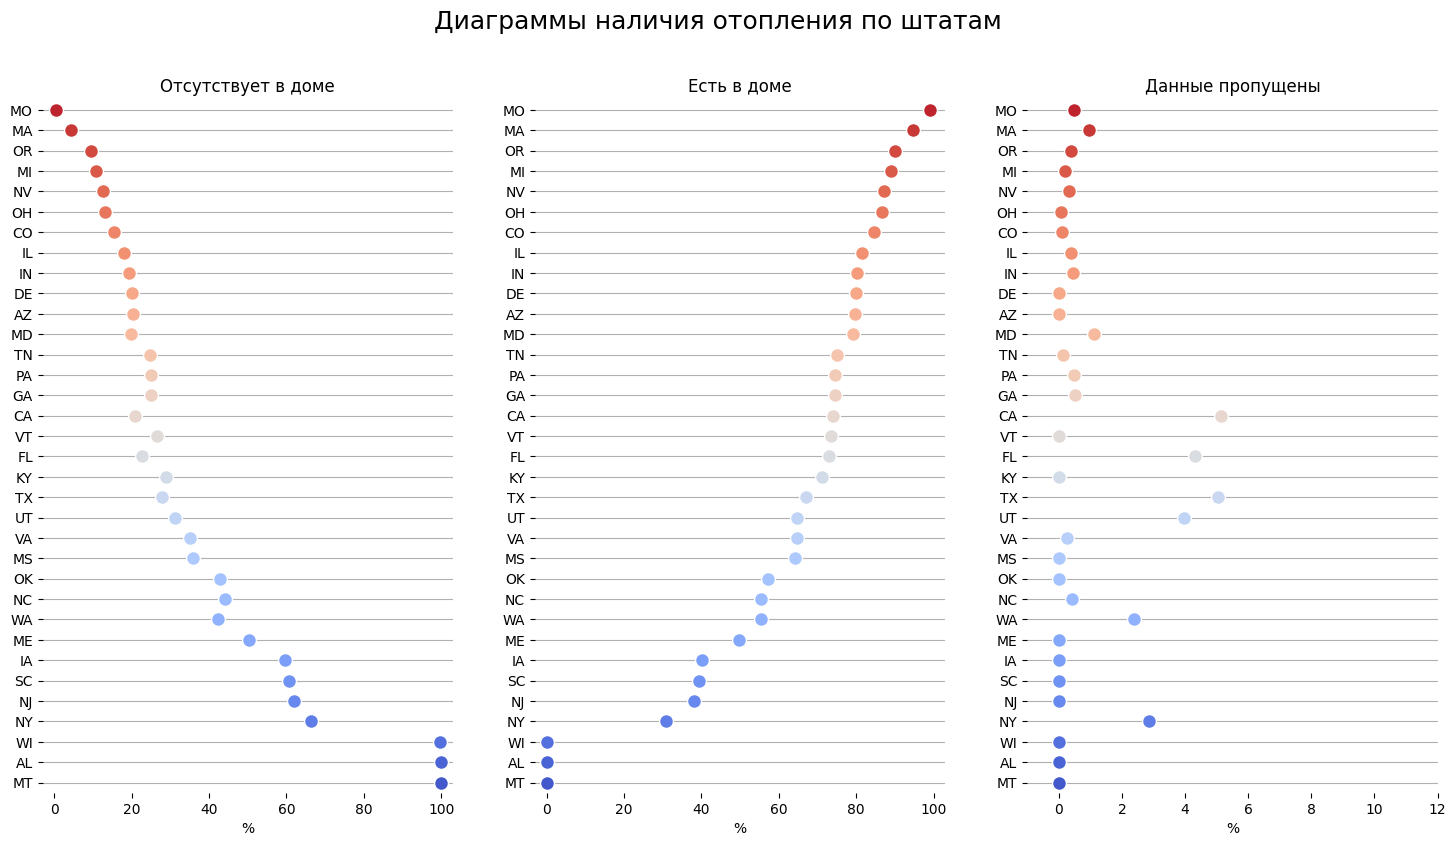

In [77]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие отопления
# в зависимости от штата, с помощью написанной функции
cross_diag('heating')

Цветовая легенда означает рейтинг штата по среднегодовой температуре: от темносинего цвета (самый холодный штат - Maine (ME) в нашем датафрейме) до темнокрасного (самый жаркий - Florida (FL)).  

Наша гипотеза состояла в том, чтобы в жарких штатах отопление в домах встречалось гораздо реже, чем в холодных. На диаграмме это должно было выглядеть, как сосредоточение красных точек в левой части диаграммы "Есть в доме". Следовательно, "холодные" штаты должны были бы сгруппироваться в правой части диаграммы "Есть в доме". (Для диаграммы "Отсутствует в доме" - все наоборот.)  

В некоторой степени, такую закономерность можно выявить. Например, на диаграмме "Отсутствует в доме" в 20% присутствуют голубые и бледно-красные точки, что означает, что в холодных штатах в порядка 20% домов нет отопления.  

По наличию отопления на диаграмме "Есть в доме" в средней части расположились жаркие штаты - от 60% до 80%. Возможно, несмотря на среднегодовую температуру, бывают дни, когда требуется отапливать дом (например, в периоды дождей).

Интересно, что на правой диаграмме "Данные пропущенны" наибольшее количество записей (от 4% до 6%) приходится почти только на жаркие штаты... Может быть, мы неверно отнесли значение None (без кавычек, тип NoneType) к пропуску, тогда как в действительности он означал отсутствие отопления в доме?..  

Пока можно сделать вывод, что одно лишь расположение дома в более жарком штате не означает, что отопление в нем отсутствует. Или наоборот - обязательно присутствует в домах из более холодных штатов. Посмотрим, как обстоят дела с кондиционированием.  

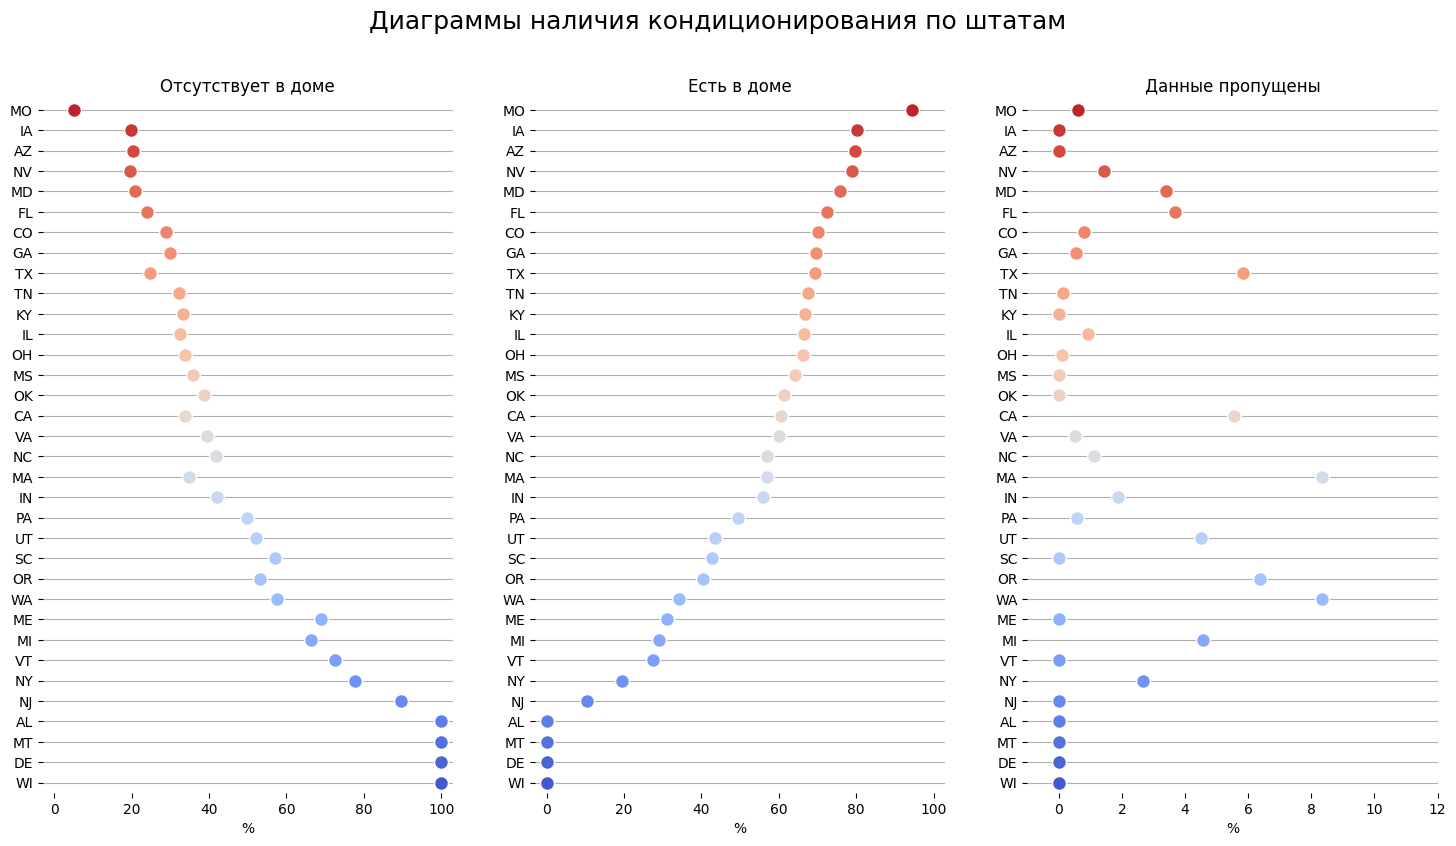

In [78]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие кондиционирования
# в зависимости от штата
cross_diag('cooling')

С кондиционированием картина более явная. На диаграмме "Отсутствует в доме" интервал от 40% до 80% домов представлен именно холодными штатами.  

"Есть в доме" кондиционирование в жарких штатах в 60% - 80% случаев.  

И снова на диаграмме "Данные пропущены" высокие значения (от 4% до 9%) представлены большей частью холодными штатами, что так же может свидетельствовать, что значение None следовало трактовать, как отсутствие кондиционирования как такового. Но, поскольку, описания значений признаков у нас нет, оставим наши текущие предположения и посмотрим на последний признак - "parking".  

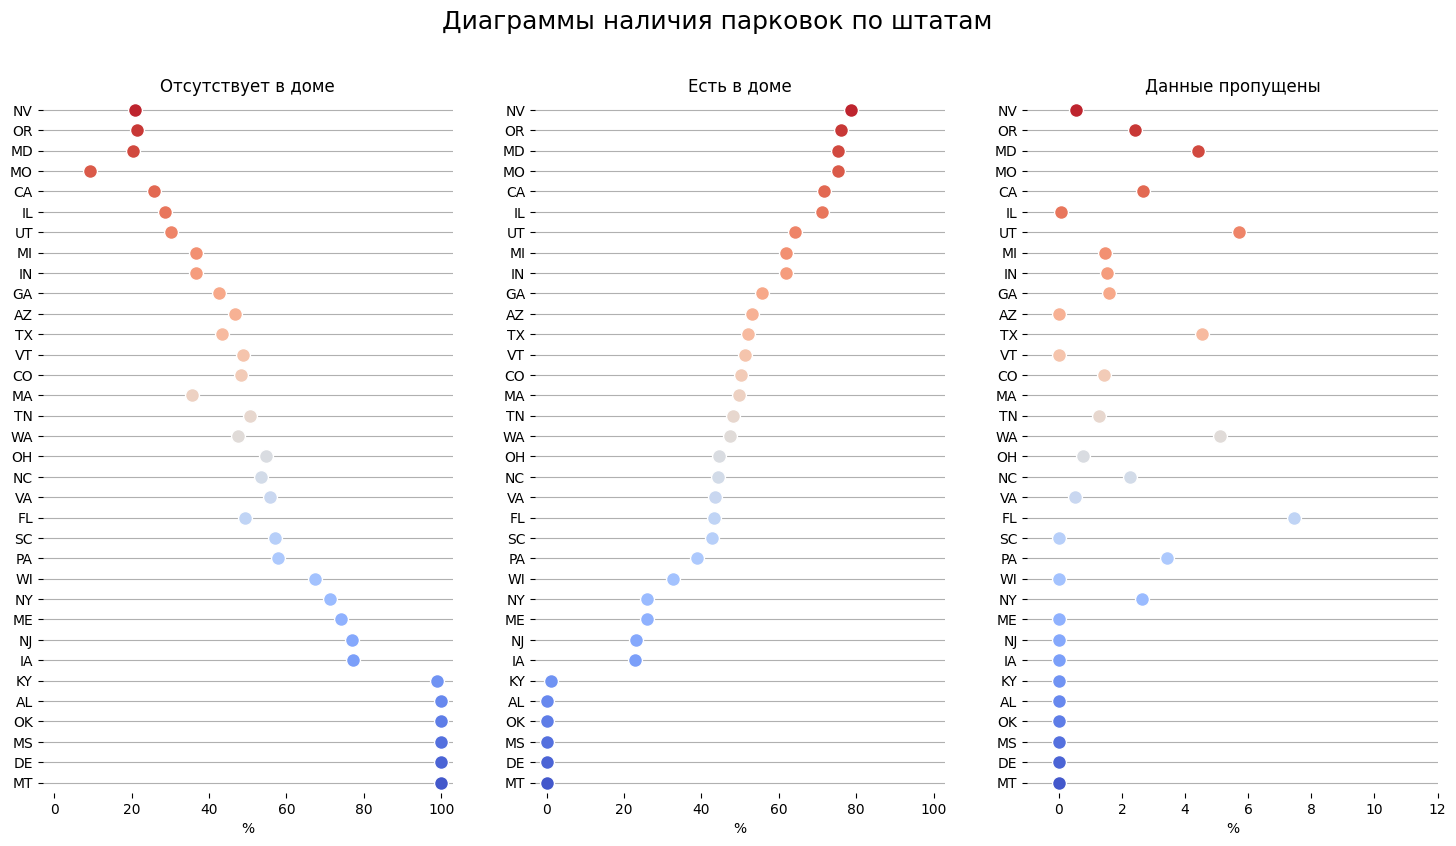

In [79]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие парковочных мест
# в зависимости от штата
cross_diag('parking')

По признаку парковок не просматривается какого-либо тренда в зависимости от расположения дома в жарком или холодном штате. Как мы и предположили в начале, более правильным представляется группировка по городам, т.к. именно размер города и его застройка (частные дома или многоквартирные небоскребы) определяют ситуацию с парковочными местами.  

Напомним, что данный шаг с построением диаграмм нужен был, чтобы решить, как заполнять пустые значения. Однако, как быть, например, с 4% пропусков в признаке отопления для штата Флориды, если в 72% домов оно установлено, а в 23% - нет?  

Разумным кажется предположить, что дополнительное оборудование увеличивает стоимость дома. Следовательно, если дом с пропущенным значением по своей цене ближе к тем 72%, где отопление установлено, то логично будет пропущенное значение заменить на положительное значение "Есть в доме" ('Yes' в датафрейме). Если же дом по цене ближе к тем, где нет отопления, значит в его признаке мы поставим отрицательное значение "Отсутствует в доме" ('No' в датафрейме).  

Таким образом, следующим шагом, мы сгруппируем все записи по признаку штата, признаку типа недвижимости (потому что в односемейном доме может быть парковка, а в квартире - нет) и заполняемому признаку ("heating" или "cooling"). Затем будем вычитать стоимость дома с пропущеным значением признака из медиан образованных групп. Наименьшая по модулю разница и определит, какое значение для конкретного типа жилья в конкретном штате записать вместо пропуска.  

In [80]:
# Функция заполнения пропусков heating и cooling
def fill_heat_cool(state: pd.Series,
                   p_type: pd.Series,
                   target: pd.Series,
                   state_gr: pd.DataFrame):
    """Функция получает на вход три признака: штат, тип собственности,
    цену дома, которые сравнивает с медианой сгруппированного
    датафрема и возвращает вектор значений для заполнения
    признака с пропусками: heating или cooling.

    Args:
        state (pd.Series): признак штата
        p_type (pd.Series): признак типа собственности
        target (pd.Series): признак целевой - цена дома
        state_gr (pd.DataFrame): датафрейм с медианами

    Returns:
        pd.Series: вектор заполненных значений
    """
    # Вычисляем разницу с медианами по штату, типу собственности
    # и значению наличия/отсутствия удобства, сортируем по
    # возрастанию от самой маленькой разницы по модулю, сохраняем
    # Series в result
    result = abs(state_gr[state][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # обработка непредвиденной ошибки индексации
        result = np.NaN

    # Возвращаем результат
    return result

In [81]:
# Сгруппируем данные по штатам, типам и заполняемому признаку, вычислим медиану цены
state_heat_gr = df.groupby(['state', 'propertyType', 'heating'])['target'].median()
state_cool_gr = df.groupby(['state', 'propertyType', 'cooling'])['target'].median()

# Сохраним индексы записей, в которых пропущены значения
ind_heat = df[df['heating'] == 'missing'].index
ind_cool = df[df['cooling'] == 'missing'].index

# Заполняем пропущенные значения в признаке heating
df.loc[ind_heat, 'heating']\
    = df.loc[ind_heat, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_heat_gr), axis=1)

# Заполняем пропущенные значения в признаке cooling
df.loc[ind_cool, 'cooling']\
    = df.loc[ind_cool, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_cool_gr), axis=1)

# Проверяем, что все пропуски заполнены
print('Количество пропусков в признаке heating:',
    df['heating'].isna().sum() + df[df['heating'] == 'missing'].shape[0])
print('Количество пропусков в признаке cooling:',
    df['cooling'].isna().sum() + df[df['cooling'] == 'missing'].shape[0])

del state_heat_gr, state_cool_gr, ind_heat, ind_cool

Количество пропусков в признаке heating: 0
Количество пропусков в признаке cooling: 0


Итак, пропуски в признаках "heating" и "cooling" мы заполнили на основании группировки по штатам.  

Для заполнения пропусков в признаке "parking" воспользуемся группировкой по городам.

In [82]:
# Функция заполнения пропусков в parking
def fill_parking(city: pd.Series,
                 p_type: pd.Series,
                 target: pd.Series,
                 city_gr: pd.DataFrame,
                 df: pd.DataFrame):
    """Функция получает на вход три признака: город, тип собственности,
    цену дома, которые сравнивает с медианой сгруппированного
    датафрема и возвращает вектор значений для заполнения
    признака с пропусками parking.

    Args:
        city (pd.Series): признак города
        p_type (pd.Series): признак типа собственности
        target (pd.Series): признак целевой - цена дома
        city_gr (pd.DataFrame): датафрейм с медианами

    Returns:
        pd.Series: вектор заполненных значений
    """
    # Вычисляем разницу с медианами по городу, типу собственности
    # и значению наличия/отсутствия удобства, сортируем по
    # возрастанию от самой маленькой разницы по модулю, сохраняем
    # Series в result
    result = abs(city_gr[city][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires, если он есть
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # если в result было единственное значение - missing, возникнет ошибка индексации
        result = df[df['city'] == city].parking.mode()[0] # присваиваем моду по городу
        if result == 'missing':
            result = np.NaN # если во всем городе - только missing, заменяем на NaN

    # Возвращаем результат
    return result

In [83]:
# Сгруппируем данные по городам, типам и заполняемому признаку, вычислим медиану цены
city_park_gr = df.groupby(['city', 'propertyType', 'parking'])['target'].median()

# Сохраним индексы записей, в которых пропущены значения
ind_park = df[df['parking'] == 'missing'].index

# Заполняем пропущенные значения в признаке parking
df.loc[ind_park, 'parking']\
    = df.loc[ind_park, ['city', 'propertyType', 'target']]\
    .apply(lambda x: fill_parking(*x, city_park_gr, df), axis=1)

# Удаляем возможные оставшиеся пропуски
# (порядка 17 городов не имеют информации о парковках)
nan_left = df['parking'].isna().sum()
if nan_left != 0:
    print(f'{nan_left} пропусков не удалось заполнить. Удалим их.')
    df.dropna(axis=0, subset='parking', inplace=True) # удаляем строки с пропусками

# Проверяем, что все пропуски заполнены
print('Количество пропусков в признаке parking:',
    df['parking'].isna().sum() + df[df['parking'] == 'missing'].shape[0])

del city_park_gr, ind_park, nan_left

19 пропусков не удалось заполнить. Удалим их.
Количество пропусков в признаке parking: 0


### 5.4. Обработка признака "lotsize"  

Этот признак иногда содержит размер участка. Очистим его, оставив только цифры, и затем попробуем использовать для заполнения пропущенных значений в признаке "sqft".  

Сразу заметим, что в "lotzise" часто встречаются площади в акрах. Акр равен 43,5 тыс. квадратных футов. Минимальное значение в признаке - 26 акров, что превышает 1 млн. квадратных футов - таких объектов нет в нашем датафрейме. Таким образом, не представляется возможным установить, к чему относится эта площадь - но, однозначно не к продаваемой недвижимости. Поэтому все ячейки, содержащие "acr" мы заменим на "No Data" для простоты последующей обработки.  

In [84]:
# Сперва избавимся от запятых и точек, отделяющих тысячные разряды
df['lotsize'] = df['lotsize'].str.replace('.', '')
df['lotsize'] = df['lotsize'].str.replace(',', '')

# Затем избавимся от всех величин площадей в акрах
ind = df[df['lotsize'].str.contains('acr', case=False) == True].index
df.loc[ind, 'lotsize'] = 'No Data'

# Наконец воспользуемся написанной ранее функцией, чтобы выделить квадратные футы
df['lotsize'] = df['lotsize'].apply(sqft_num).astype(float)

In [85]:
# Задаем маски непустых и ненулевых значений
m1 = df.sqft.isna() == False
m2 = df.sqft != 0
m3 = df.lotsize.isna() == False
m4 = df.lotsize != 0

# Сохраняем индексы таких записей и выводим размерность
ind = df[m1 & m2 & m3 & m4].index
print('Записей с непустым sqft и lotsize:', len(ind))

Записей с непустым sqft и lotsize: 179193


In [86]:
# Создадим признак отношения и заполним его, где возможно
df['sqft_ratio'] = 0
df.loc[ind, 'sqft_ratio'] = df.loc[ind, 'lotsize'] / df.loc[ind, 'sqft']

# Сгруппируем коэффициент отношения по типу недвижимости и вычислим медиану
ratio_gr = df.loc[ind].groupby('propertyType')['sqft_ratio'].median()
display('Отношение lotsize к sqft среди непустых значений:', ratio_gr.round(2))

'Отношение lotsize к sqft среди непустых значений:'

propertyType
Condo            1.00
Land             2.97
Multifamily      1.72
Single family    3.58
Townhouse        1.02
Name: sqft_ratio, dtype: float64

Ожидаемо, размер участка земли "Land" больше площади дома "sqft", который можно на нем построить, поэтому мы видим медианный коэффициент в размере 2.97.  

Примерно в половину меньше коэффициент у односемейных домов. По всей вероятности, он появился из-за дорогих домов, имеющих большую территорию (однажды построенных на как раз таких участках "Land").  

Наименьший коэффициент - у квартир "Condo" и "Townhouse", которые располагаются в городах, где придворовая территория невелика. Все выглядит довольно логично.  

Однако в число записей, которые мы сможем заполнить вычисленным значением, входят большей частью в записи, помеченные как выбросы при обработке "target", то есть большая часть заполненных нами значений будет удалена. А кроме этого, вычисленные значения иногда получаются очень неточными (по сравнению с делением "target" на "price_sqft", как мы увидим дальше), поэтому, как не обидно, но от идеи использования этого признака нам придется отказаться.  

In [87]:
# Удаляем ненуженые признаки
df = df.drop(['lotsize', 'sqft_ratio'], axis=1)

del ratio_gr, ind, m1, m2, m3, m4 # очищаем память

### 5.5. Обработка признака "price_sqft"  

По традиции, очистим вначале признак от текста, сохранив только числа - цену за квадратный фут.  

Нули заменим на np.NaN для удобства дальнейшей работы. А также сразу удалим (обозначим как np.NaN) такие значения, которые совпадают со стоимостью всей недвижимости.  

Затем вычислим площадь недвижимости, разделив ее стоимость "target" на цену за кв. фут "price_sqft" и сохраним в признак "true_sqft". Из этого признака заменим пропуски в признаке "sqft".

In [88]:
# Сперва избавимся от знака $, запятых и точек, отделяющих тысячные разряды
df['price_sqft'] = df['price_sqft'].str.replace('$', '')
df['price_sqft'] = df['price_sqft'].str.replace(',', '')
df['price_sqft'] = df['price_sqft'].str.replace('.', '')

# Наконец воспользуемся написанной ранее функцией, чтобы выделить цену за квадратный фут
df['price_sqft'] = df['price_sqft'].apply(sqft_num).astype(float)

# Обозначим как пропуск цены, равные стоимости участка, а также все нули
ind = list(df[df['price_sqft'] == df['target']].index)
ind.extend(list(df[df['price_sqft'] == 0].index))
df.loc[ind, 'price_sqft'] = np.NaN

In [89]:
# Задаем маски пустых и нулевых значений
m1 = df.sqft.isna() == True
m2 = df.price_sqft.isna() == True

print('Непустые значения price_sqft:', df[~m2].shape[0])
print('Пустые значения sqft:', df[m1].shape[0])
print('Пересечение непустых price_sqft и пустых sqft:', df[m1&~m2].shape[0])

Непустые значения price_sqft: 309696
Пустые значения sqft: 52488
Пересечение непустых price_sqft и пустых sqft: 1246


In [90]:
# Сохраняем индексы записей с непустыми ячейками price_sqft
ind = df[~m2].index
# Вычисляем площадь дома, а также разницу с признаком sqft
df.loc[ind, 'true_sqft'] = (df.loc[ind, 'target'] / df.loc[ind, 'price_sqft']).astype(int)
df.loc[ind, 'sqft_dif'] = abs(df.loc[ind, 'sqft'] - df.loc[ind, 'true_sqft'])

# Сохраняем индексы пересечения
ind = df[m1&~m2].index
# Заполняем пропуски в sqft с помощью вычисленных значений
df.loc[ind, 'sqft'] = df.loc[ind, 'true_sqft']

Приходится признать, что десериализованный признак "price_sqft" не сильно помог нам в заполнении пропусков в признаке "sqft" (всего 1246 записей из 52443). Однако заранее мы этого не могли знать.  

### 5.6. Фильтрация записей по признакам "sqft" и "price_sqft"   

Настала пора избавиться от выбросов и пустых значений в ключевом признаке sqft.  

С этой целью мы проверим на выбросы с помощью метода z-отклонений два признака:  
- "sqft",  
- "price_sqft".

Определенные выбросы пометим флагами в соответствующих новых признаках.  
Таким образом, вкупе с созданным ранее столбцом выбросов "outliers" для целевого признака "target" мы отсеем такие объявления, которые выбиваются из общей массы по одной из этих независимых характеристик (независимых потому, что в датафрейме значения, сохраненные в этих признаках, могут быть не связаны).  

Мы также посмотрим, как распределена ошибка расчетной площади с имевшейся в датафрейме (новый признак "sqft_dif").  

In [91]:
# Функция вывода на экран гистограммы распределения признака
def draw_hist(df: pd.DataFrame,
              feat: str,
              left: int,
              right: int,
              log_scale: bool = True,
              bins: int = 50):
    """Функция выводит на экран гистограмму распределения признака
    (при необходимости в логарифмическом масштабе), отрисовывает
    нижнюю и верхнюю границы отклонений.

    Args:
        df (pd.DataFrame): исходный датафрейм
        feat (str): иллюстрируемый признак
        left (int): кол-во сигм для нижней границы
        right (int): кол-во сигм для верхней границы
        log_scale (bool: optional): переход к лог. масштабу, по умолчанию = True
        bins (int: optional): кол-во столбцов, по умолчанию = 50

    Returns:
        None: функция ничего не возвращает
    """

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feat].min() > 0: # если значения признака больше 0
            log_target = np.log(df[feat])
        else:
            log_target = np.log(df[feat]+1) # иначе добавляем единицу
    else:
        log_target = df[feat]

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + right * log_target.std()
    lower_bound = log_target.mean() - left * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = bins
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {feat}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');

    return

Число выбросов по методу z-отклонений для price_sqft: 4242
Результирующее число записей для price_sqft: 305454


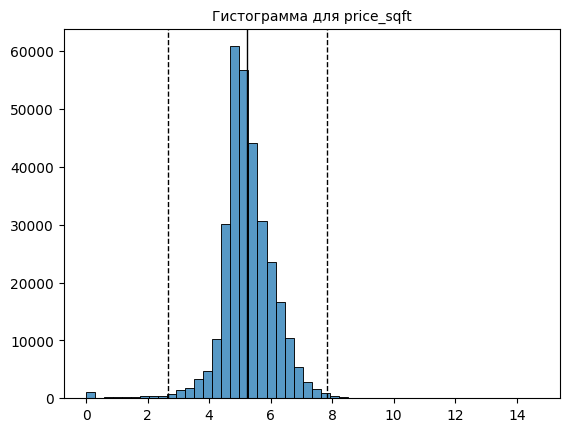

In [92]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'price_sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_price_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_price_sqft'] = 1

# Отрисуем гистограмму
draw_hist(df, feat, left, right)

Число выбросов по методу z-отклонений для sqft: 2478
Результирующее число записей для sqft: 319296


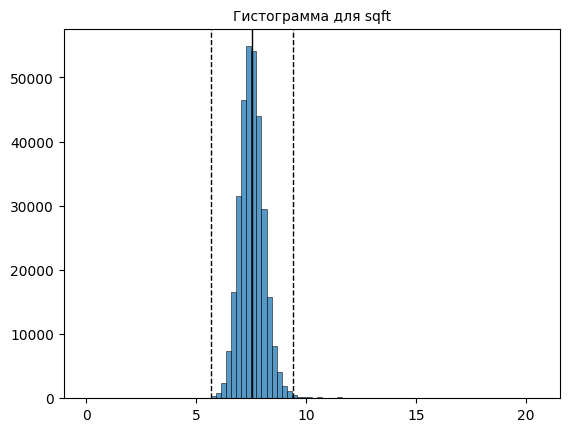

In [93]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_sqft'] = 1

# Отрисуем гистограмму
draw_hist(df, feat, left, right, bins=90)

In [94]:
# Объединяем все флаги выбросов по трем признакам в один
df['total_outliers'] = df['outliers'] + df['outliers_sqft'] + df ['outliers_price_sqft']
print('Всего к выбросам отнесено записей:', df[df['total_outliers'] > 0].shape[0])

Всего к выбросам отнесено записей: 22028


Число выбросов по методу z-отклонений для sqft_dif: 3077
Результирующее число записей для sqft_dif: 305373


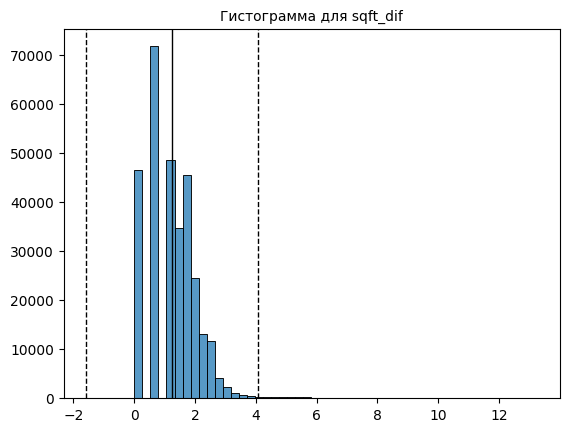

In [95]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft_dif'

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран (признак с флагами не создавали)
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')

# Отрисуем гистограмму
draw_hist(df, feat, left, right, log_scale=True)

Посмотрим, как разница между вычисленным значением площади и тем, что было изначально в датафрейме "sqft_dif", распределилась по типам недвижимости.

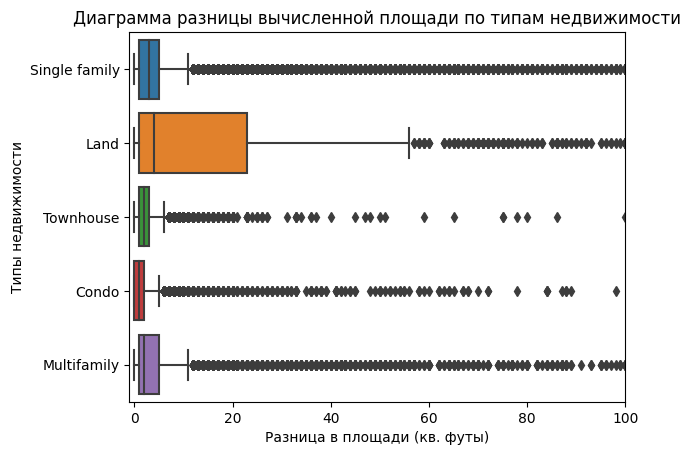

In [96]:
# Построим коробчатую диаграмму
boxplot = sns.boxplot(
    data = df,
    x = 'sqft_dif',
    y = 'propertyType'
);
boxplot.set(xlim=(-1, 100)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма разницы вычисленной площади по типам недвижимости');
boxplot.set_xlabel('Разница в площади (кв. футы)');
boxplot.set_ylabel('Типы недвижимости');

Видно, что самое большое значение 1,5 межквартильных размаха приходится на тип "Land" - в районе 60 кв. футов. Примем за выбросы все значения разницы выше этого. Проверим, какое количество записей находятся по одну и по другую границу, а также сравним, какой процент из них входит в определенные нами выбросы по другим признакам.

In [97]:
print('Записей с разницей выше 60 кв. футов:', df[df['sqft_dif'] > 60].shape[0])
print('Записей с разницей меньше или равно 60 кв. футов:', df[df['sqft_dif'] <= 60].shape[0])

dif_in_out = round(df[(df['sqft_dif']>60)\
                      & (df['total_outliers']>0)].shape[0]\
                   / df[df['total_outliers']>0].shape[0]*100)

print(f'Доля записей с разницей выше 60 кв. футов в выбросах: {dif_in_out}%')

Записей с разницей выше 60 кв. футов: 3013
Записей с разницей меньше или равно 60 кв. футов: 305437
Доля записей с разницей выше 60 кв. футов в выбросах: 11%


В отобранные нами выбросы по признакам "sqft" и "price_sqft" попали 11% записей, где разница между расчетной и исходной площадью превышает 60 кв. футов. При уменьшении разницы до 40 кв. футов  мы бы получили 13% вхождения. Таким образом, выбросы в признаке "sqft_dif" можно считать погрешностью в объёме всех выбросов. Поэтому специально удалять эти записи мы не будем, а произведём очистку датафрейма на основании их вхождения в список выбросов по трём признакам: исходная площадь (пропуски которой мы частично заполнили), цена за кв. фут и итоговая стоимость.  

Также в список на удаление добавим записи, у которых площадь равна или превышает стоимость. Это невозможно, поскольку означало бы, что квадратный фут стоит один доллар или меньше. Таких записей в нашем датафрейме немногим более 800.   

In [98]:
# Формируем список на удаление: выбросы и неадекватная площадь
ind = set(df[df['total_outliers'] > 0].index)
ind.update(df[df['sqft'] >= df['target']].index)
df = df.drop(list(ind), axis=0)

# Удалим ненужные признаки
df = df.drop(['outliers','outliers_sqft', 'outliers_price_sqft',
              'total_outliers', 'true_sqft', 'sqft_dif'], axis=1)

# Проверим, сколько пропусков остается
print(f'Все еще остается {df.sqft.isna().sum()} пропуска в признаке sqft')
print(f'Это составляет {round(df.sqft.isna().sum()/df.shape[0]*100,2)}% датафрейма')

# Удаляем записи с оставшимися пропусками
df.dropna(axis=0, subset='sqft', inplace=True)
print('Эти записи удалены')

Все еще остается 45037 пропуска в признаке sqft
Это составляет 12.83% датафрейма
Эти записи удалены


Теперь, когда мы удалили выбросы, мы можем вернуться к построение диаграммы зависимости стоимости недвижимости от ее площади.  

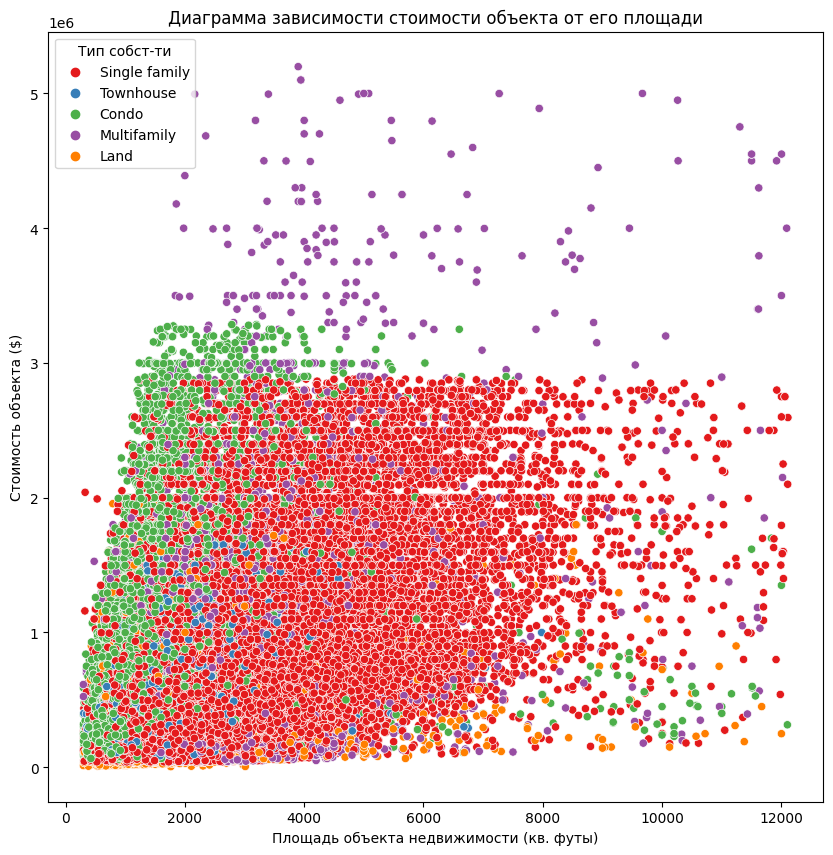

In [99]:
# Построим диаграмму зависимости стоимости от площади
fig = plt.figure(figsize=(10, 10))
scatterplot = sns.scatterplot(
    data = df,
    x = 'sqft',
    y = 'target',
    hue = 'propertyType',
    palette = 'Set1'
);
scatterplot.set_title('Диаграмма зависимости стоимости объекта от его площади');
scatterplot.set_xlabel('Площадь объекта недвижимости (кв. футы)');
scatterplot.set_ylabel('Стоимость объекта ($)');
scatterplot.legend(title = 'Тип собст-ти');

Несмотря на удаление выбросов, диаграмма не стала более информативной. Полезно было бы применить алгоритмы понижения размерности, но мы справимся с обработкой данных другими способами, а пока все же попробуем уловить какие-то закономерности на этой диаграмме.  

Ожидаемо с увеличенем площади растет и цена, хотя есть большие по площади объекты, которые остаются дешевыми. Что это: непопулярные территории или оставшиеся выбросы? Последних мы уже удалили достаточно. Поэтому будет считать это особенностью этих объектов.  

Четко просматриваются горизонтальные линии среди всех типов недвижимости - пристрастие людей к круглым числам. Особенно мало остается объектов после \$275 - 300 тыс. И они в основном принадлежат типу многосемейных домов.  

В распределении не просматривается строгая линейная зависимость, вот почему применение модели линейной регрессии будет недостаточно для получения хороших результатов.  

### 5.7. Обработка признака "school"  

В этом признаке содержится сериализованный словарь данных о близлежащих школах:  
- рейтинг школы по десятибальной шкале,  
- расстояние до школы в милях,  
- классы школы (начальные, средние и др.),  
- название школы.  

Одним из подходов могло бы стать выделение типов школ по классам (подготовительные, начальные, средние) в несколько общих признаков, а затем для каждого объекта недвижимости заполнение этих признаков с помощью рейтинга и расстояния до школы. Но мы поступим проще.  

Скорее всего, владельцам недвижимости-родителям хочется иметь близко к дому школу с высоким рейтингом. А лучше - несколько, т.к. ребенок растет и переходит из одной в другую. Мы игнорируем возрастные классы и сосредоточимся лишь на рейтинге и расстоянии до школ.  

Очевидно, что чем выше рейтинг и чем ближе школа, тем лучше. Поэтому мы выведем свой, совокупный рейтинг в виде среднего арифметического рейтингов, деленных на расстояния. Таким образом, высокий рейтинг школы компенсирует большое расстояние до нее. Зато школа с рейтингом ниже, но по соседству, тоже продемонстрирует высокий совокупный рейтинг.  

Вместе с тем, наш совокупный рейтинг не будет отражать, какое количество школ расположено пососедству от объекта недвижимости. Поэтому, чтобы не терять эту информацию, выделим еще один признак - количество школ. Это будет не что иное, как длина списка расстояний.  

Напишем несколько функций: для десериализации признака "schools", для преобразования текстовых списков к числовым и для вычисления среднего арифметического нашего рейтинга.  

In [100]:
# Функция десериализации признака school
def deserialize_school(s: str) -> pd.Series:
    """Функция возвращает значения словаря, который находится
    в сериализованном виде в строке s.

    Args:
        s (str): строка с сериализованным словарем

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """

    # Десериализуем строку в словарь и сразу сохраним его единственое значение
    result = eval(s)[0]

    # В единственном значении словаря хранится словарь из 3 элементов,
    # каждый из которых представлен списками (за исключением второго - data,
    # у которого два списка обернуты в словарь).
    # Вернем рейтинги и расстояние до школ
    rating = result['rating']
    distance = result['data']['Distance']

    # Возвращаем списки в виде объекта Series
    return pd.Series([rating, distance])

In [101]:
# Функция преобразования списка строк в список числовых значений
def clear_list(str_list: list) -> list:
    """Функция преобразует список строковых значений,
    в список числовых. При этом функция выделяет первое
    число в рейтинге (4/10 -> 4) и расстояние обозначенное
    с помощью "mi".

    Args:
        str_list (list): список строковых значений

    Returns:
        list: список значений, преобразованных в числовой вид
    """

    # Скомпилируем паттерны для поиска в признаках rating и dist
    p_rat = re.compile('(\d+)/?')
    p_dis = re.compile('(\d+\.?\d*)\s*mi')

    if len(str_list) == 0: # если в ячейке пустой список
        result = np.NaN
    elif 'NR' in str_list: # если в списке содержится 'NR'
        result = [int(r) if r.isdigit() else np.NaN for r in str_list]
    elif len(list(filter(p_dis.search, str_list))) > 0: # если в списке содержится расстояние
        result = [float(p_dis.search(r).group(1)) if p_dis.search(r)\
                  else np.NaN for r in str_list]
    elif len(list(filter(p_rat.match, str_list))) > 0: # если в списке рейтинг со слэшами
        result = [int(p_rat.match(r).group(1)) if p_rat.match(r)\
                  else np.NaN for r in str_list]
    else:
        result = np.NaN # в крайнем случае вернем np.NaN

    # Возвращаем преобразованный список
    return result

In [102]:
# Функция вычисления среднего арифметического списков
def mean_lists(rating: list, dist: list) -> float:
    """Функция вычисляет среднее арифметическое двух списков,
    состоящих из числовых значений. Вначале она делит рейтинги
    на расстояния, затем получившийся список частных преобразует
    в объект pd.Series и вычисляет среднее арифметическое.
    Перед делением функция заменяет нулевые расстояния на 0.1
    (минимальное встречающееся в датафрейме), чтобы избежать
    бесконечности (np.inf) в ответе.

    Args:
        rating (list): список рейтингов школ
        dist (list): список расстояний до школ

    Returns:
        float: средне-арифметический коэффициент
    """

    if type(rating) == list and type(dist) == list:
        # Нулевые расстояния заменим на минимальные, чтобы избежать inf
        dist = list(map(lambda x: 0.1 if x==0 else x, dist))
        mult = list(np.divide(rating, dist)) # делим рейтинг на расстояние
        result = pd.Series(mult).mean() # вычисляем ср. арифм.
    else:
        result = np.NaN # если на вход поданы не списки, вернем np.NaN

    # Возвращаем результат работы функции
    return result

In [103]:
# Десериализуем признак schools
df[['sch_rating', 'sch_dist']] = df['schools'].apply(deserialize_school)

# Генерируем два новых признака с рейтингами и расстояниями до школ
df['sch_rating'] = df['sch_rating'].apply(clear_list)
df['sch_dist'] = df['sch_dist'].apply(clear_list)

# Вычисляем совокупный рейтинг
df['sch_rat_dist'] = df[['sch_rating', 'sch_dist']]\
                     .apply(lambda x: mean_lists(*x), axis=1).round()

# Сохраняем в отдельный признак количество школ
try:
    df['sch_number'] = df['sch_dist']\
                   .apply(lambda x: len(x) if x is not np.NaN else np.NaN)
except: # после чтения из файла список хранится как строка, что вызывает ошибку
    df['sch_number'] = df['sch_dist']\
                      .apply(lambda x: len(eval(x)) if x is not np.NaN else np.NaN)

In [104]:
# Взглянем на описание созданного нами признака совокупного рейтинга
df['sch_rat_dist'].describe()

count    302780.000000
mean          6.026805
std           6.560396
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         333.000000
Name: sch_rat_dist, dtype: float64

In [105]:
# А также посмотрим на количество школ, которые окружают дома
df['sch_number'].describe()

count    303491.000000
mean          4.185386
std           4.449259
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: sch_number, dtype: float64

Как видим, медианный рейтинг равен примерно 4 единицам, а ТОП-10 представлен всеми значениями от 1 до 10 включительно. Ноль не входит, что означает, что до школ людям приходится ездить.

Встречаются и аномальные значения вплоть до 333. Есть такие объекты недвижимости, где школа (по ее названию и расстоянию до нее) удалена на сотни и даже тысячи миль. 

Что касается количества школ, то, как правило, родители могут выбрать из 3-4. Правда, есть случаи, когда в районе находится 65 школ (вопрос расстояния до них).  

Так или иначе, мы не станем удалять какие-либо записи по причине аномально большого рейтинга школы или их количества. А вот с пустыми значениями разберемся (их около 5000). Поступим, как с другими признаками: заполним пропуски медианой, характерной для типа недвижимости, ведь, если вдуматься, для квартир в городах, школы должны быть ближе, чем для частных домов в небольших городках.  

In [106]:
# Вычислим медиану совокупного рейтинга для каждого из типов жилья
proper_sch_rat_med = df.groupby('propertyType')['sch_rat_dist'].median()
# Вычислим медиану количества школ для каждого из типов жилья
proper_sch_num_med = df.groupby('propertyType')['sch_number'].median()

# Запускаем цикл по всем типам недвижимости
for p in proper_sch_rat_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['sch_rat_dist'].isna() == True # маска по пропускам в sch_rat_dist
    mask3 = df['sch_number'].isna() == True # маска по пропускам в sch_number
    ind = df[mask1 & mask2]['sch_rat_dist'].index # сохраняем индекс
    df.loc[ind, 'sch_rat_dist'] = proper_sch_rat_med[p] # присваиваем медиану рейтингу

    ind = df[mask1 & mask3]['sch_number'].index # сохраняем индекс
    df.loc[ind, 'sch_number'] = proper_sch_num_med[p] # присваиваем медиану кол-ву школ

# Проверяем результаты заполнения
print('Осталось пропущенных значений в признаке sch_rat_dist:',
      df['sch_rat_dist'].isna().sum())
print('Осталось пропущенных значений в признаке sch_number:',
      df['sch_number'].isna().sum())

# Удаляем ненужные более признаки
df = df.drop(['schools', 'sch_rating', 'sch_dist'], axis=1)

Осталось пропущенных значений в признаке sch_rat_dist: 0
Осталось пропущенных значений в признаке sch_number: 0


### 5.8. Генерация признака столицы штата "state_cap"  

Ранее мы выдвинули гипотезу, что стоимость недвижимости в столицах штатов может отличаться от прочих городов. Чтобы проверить ее, создадим новый признак. Для этого скачаем список всех штатов с их аббревиатурами и столицами и добавим к нашему датафрейму. Выставим флаг того, расположен ли объект недвижимости в столице штата и посмотрим на результаты.  



In [107]:
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://bigdave44.com/features/the-mine/us-states-abbreviations-capitals-nicknames/'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием, аббревиатурой и столицей штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура, столица
states_cap = [r_d.text for r_d in raw_data][4:203]

# Фомируем датафрем из названий аббревиатур штатов и столиц
cap_df = pd.DataFrame(list(zip(states_cap[1::4],
                               states_cap[2::4])),
                      columns = ['state', 'capital'])
# Переводим все столицы в нижний регистр (как в датафрейме)
cap_df['capital'] = cap_df['capital'].str.lower()

# Добавляем получившийся датафрейм к основному
df = pd.merge(
    left = df,
    right = cap_df,
    on = 'state',
    how = 'left'
)

In [108]:
# Генерируем признак нахождения в столице штата
df['in_st_capital'] = df[['city', 'capital']]\
                      .apply(lambda x: 1 if x.city == x.capital else 0, axis=1)

# Проверим, сколько объектов расположены в столицах штатов
obj = df['in_st_capital'].sum()
shr = round(obj / df.shape[0] * 100)
print(f'В столицах расположено {obj} объектов, что составляет {shr}% от датафрейма.')

# Удаляем ненужный столбец и чистим память
df = df.drop('capital', axis=1)
del url, response, page, raw_data, states_cap, cap_df, obj, shr

В столицах расположено 24020 объектов, что составляет 8% от датафрейма.


Доля объектов в столицах штатов невелика, больше похожа на погрешность. Интересно посмотреть, как этот признак повлияет на стоимость недвижимости.  

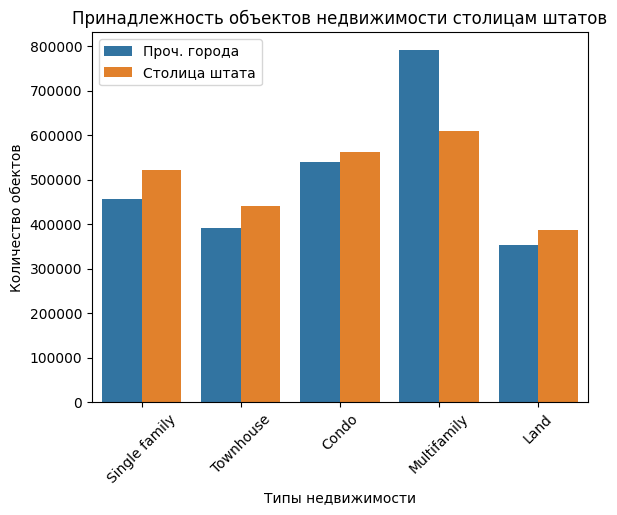

In [109]:
# Проиллюстрируем нашу гипотезу
barplot = sns.barplot(
    data = df,
    x = 'propertyType',
    y = 'target',
    hue = 'in_st_capital',
    errorbar = None
);
barplot.set_title('Принадлежность объектов недвижимости столицам штатов');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество обектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.legend(labels=['Проч. города', 'Столица штата']);

На диаграмме видно, что почти все объекты недвижимости, кроме многосемейных домов, чаще располагаются в столицах штатов. Однако превышение незначительное.

Более того, в первых итерациях работы над проектом, когда мы не удаляли большого колчиества выбросов при обработке признака "target" в пункте 3.11, картина была диаметрально противоположной: почти все объекты (за исключением "Land") находились чаще всего вне столиц штатов (та диаграмма не сохранилась)!  

Приходим к выводу, что какого-либо тренда по жизни в столицах штатов или наоборот за их пределами, выявить не удалось. Скорее всего, объясняется это несколькими факторами:  
- децентрализация,  
- многочисленные города-сателлиты, расположенные в непосредственной близости со столицей, но относящиеся к другой категории.  

Таким образом, жидать существенного вклада данного признака в качество модели не приходится.  

### 5.9. Кодирование признаков  

Наконец, мы закончили обрабатывать и исследовать данные. Конечно, можно было бы построить дополнительные диаграммы, иллюстрирующе зависимости в данных. Однако совсем не обязательно, что такие гипотезы повлияли бы на конечный результат.  

Перейдем же к непосредственной подготовке данных к подаче на вход моделям обучения. И начнем с кодирования признаков. Первым делом удалим не нужные более признаки. Затем категориальные преобразуем в числовые:  
- где просто, вручную заменим бинарные значения на 1 и 0,  
- в остальных случаях прибегнем к помощи кодировщиков.  

In [110]:
# Удаляем ненужные признаки
df = df.drop(['street', 'homeFacts', 'city', 'price_sqft'], axis=1)

# Кодируем признаки с бинарными значениями
df['heating'] = df['heating'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['cooling'] = df['cooling'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['parking'] = df['parking'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# Удаляем записи с оставшимися пропусками
df.dropna(inplace = True)

# Отобразим кол-во уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status           5
propertyType     5
state           33
stories          4
dtype: int64

In [111]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df[oh_cols])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df[['state']])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
df = df.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося датафрейма:', df.shape)

Размер получившегося датафрейма: (305950, 31)


### 5.10. Оценка мультиколлинеарности признаков  

Проверим, нет ли сильной связи между признаками нашего датафрейма по методу Пирсона, особенно после генерации дополнительных.  

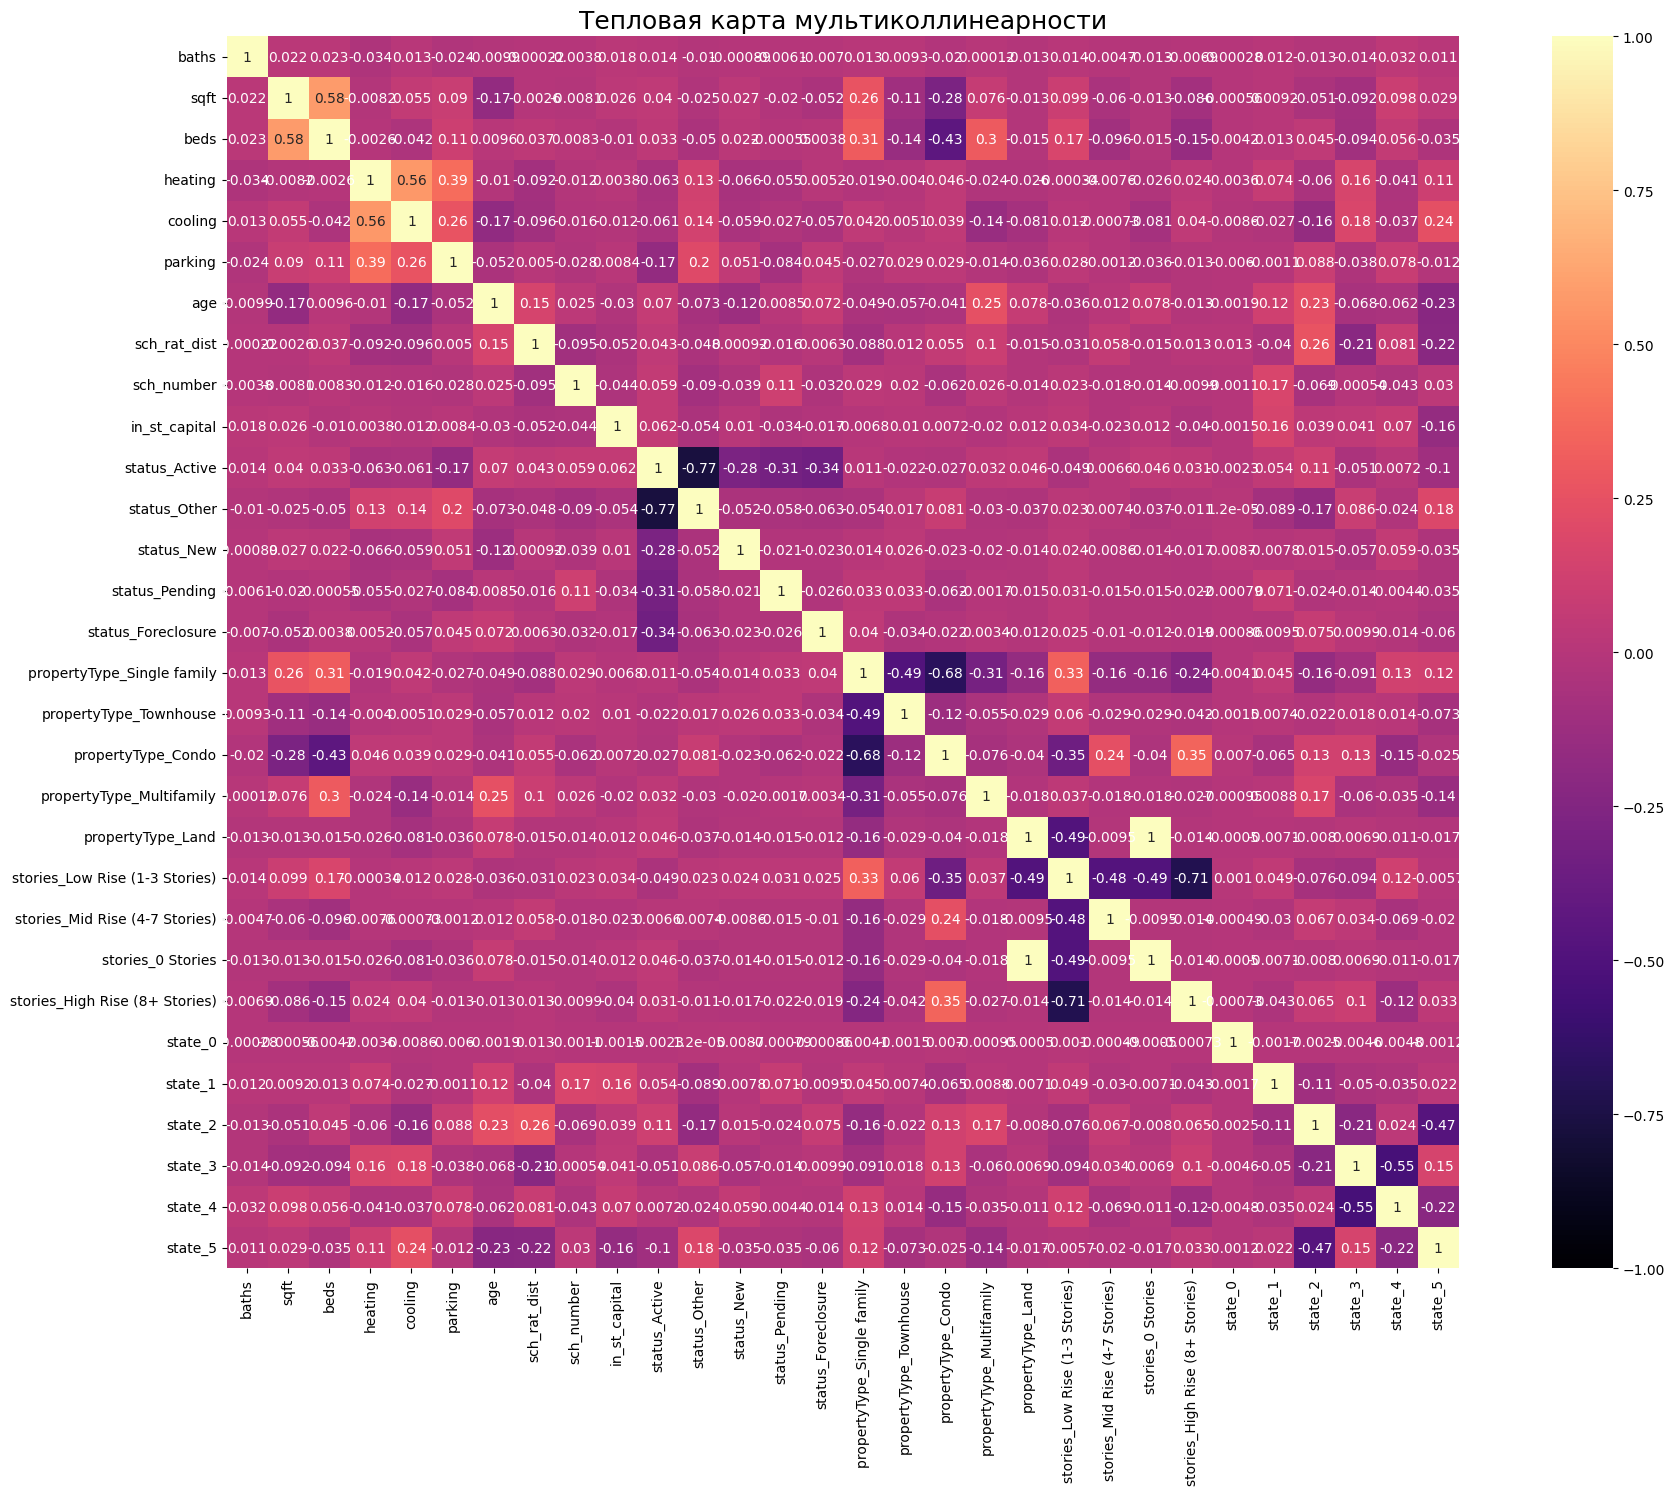

In [112]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = df.drop('target', axis=1).corr(method='pearson'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'magma',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Сразу бросается в глаза абсолютная связь признаков "propertyType_Land" и "stories_0 Stories". Удивляться не приходится - мы ведь сами на этапе очистки присвоили данному типу недвижимости категорию нулевых этажей.  

Поскольку недвижимости с нулем этажей нет (это только участки), то представляется целесообразным избавиться от признака "stories_0 Stories". Все остальные можно оставить.

Отметим вполне ожидаемую связь между площадью строения и количеством ванных комнат и спален. Однако никаких манипуляций с этим признаками мы проводить не станем.  

Перед удаленим "stories_0 Stories" проведем несколько тестов на оценку значимости признаков.   

### 5.11. Оценка значимости и отбор признаков  

Сначала с помощью SelectKBest попробуем отобрать 20 лучших признаков из наших 29. Затем проведем хи-тест и тест  ANOVA для категориальных и непрерывных признаков.  

Все это позволит нам принять взвешенное решение, какие признаки удалять, а какие оставить в итоговых выборках.  

По итогу этого шага разделим датафрейм на тренировочные и тестовые выборки и векторы ответов для подачи на вход модели.  

#### Отбор лучших признаков с помощью SelectKBest

In [113]:
# Создаем объект класса SelectKBest
kbest = SelectKBest(score_func=f_regression, k=20)

# Подгоняем его под данные и получаем список лучших 20 признаков
kbest.fit(df.drop('target', axis=1), df['target'])
kbest_columns = kbest.get_feature_names_out()

# Посмотрим, какие признаки не вошли в число лучших
display('Не вошли в число лучших признаков:',
        set(df.drop('target', axis=1).columns).difference(set(kbest_columns)))

'Не вошли в число лучших признаков:'

{'age',
 'baths',
 'cooling',
 'in_st_capital',
 'propertyType_Land',
 'state_0',
 'status_New',
 'status_Other',
 'stories_0 Stories',
 'stories_Mid Rise (4-7 Stories)'}

Метод SelectKBest подтвердил, что нам стоит избавиться от "propertyType_Land" и "stories_0 Stories". Также в число лучших не вошел сгенерированный "in_st_capital".  

Проведем дополнительные тесты перед принятием решения.  

#### Тест хи-квадрат для категориальных признаков  

In [114]:
# Разделим все признаки на два списка: категориальные и непрерывные
cat_cols = ['baths', 'beds', 'heating','cooling', 'parking',
            'in_st_capital', 'status_Active', 'status_Other',
            'status_New', 'status_Pending', 'status_Foreclosure',
            'propertyType_Single family', 'propertyType_Townhouse',
            'propertyType_Condo', 'propertyType_Multifamily', 'propertyType_Land',
            'stories_Low Rise (1-3 Stories)', 'stories_Mid Rise (4-7 Stories)',
            'stories_0 Stories', 'stories_High Rise (8+ Stories)', 'state_0',
            'state_1', 'state_2', 'state_3', 'state_4', 'state_5']

num_cols = ['sqft', 'age', 'sch_rat_dist', 'sch_number']

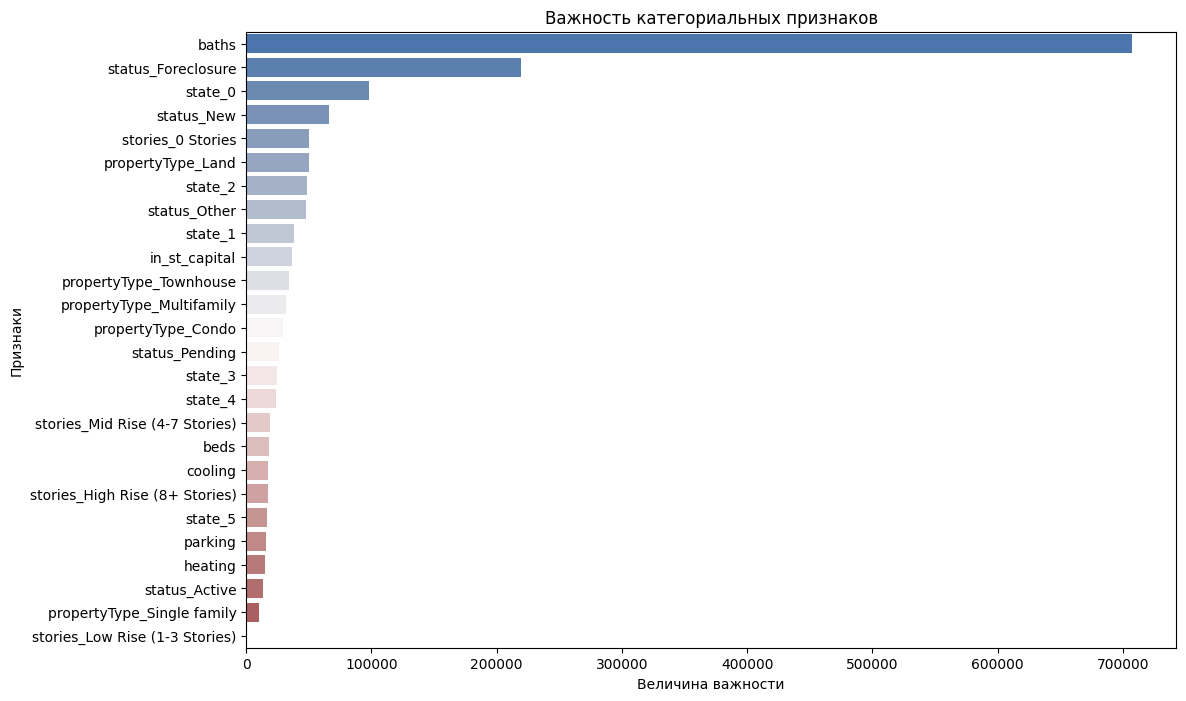

In [115]:
# Воспользуемся тестом хи-квадрат и проиллюстрируем его результаты
imp_cat = pd.Series(chi2(df[cat_cols], df.target)[0], index=cat_cols)
imp_cat = imp_cat.sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = imp_cat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность категориальных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

#### Тест ANOVA для непрерывных признаков  

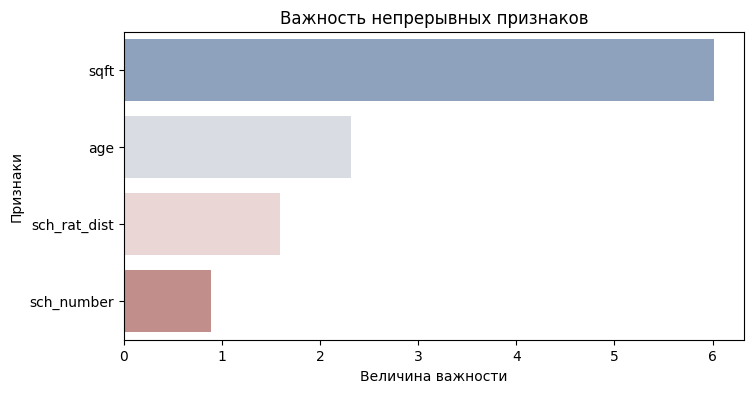

In [116]:
# Воспользуемся тестом ANOVA и проиллюстрируем его результаты
imp_num = pd.Series(f_classif(df[num_cols], df.target)[0], index = num_cols)
imp_num = imp_num.sort_values(ascending=False)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = imp_num.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность непрерывных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Отметим, что по результатам теста ANOVA, как и следовало ожидать, площадь недвижимости является главным признаком среди остальных непрерывных с точки зрения влияния на стоимость объекта.

Проведя тесты, мы готовы разделить датафрейм на обучающие и тестовые выборки (перед возможной нормализацией).  

In [117]:
# Разделяем датафрейм и готовим выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(214165, 30) (91785, 30) (214165,) (91785,)


### 5.12. Нормализация и стандартизация  

Эксперименты показали, что нормализация и стандартизация наших данных не дают прироста метрики, но даже несколько ухудшают ее. Поэтому обернем код в функции, чтобы при прогоне программы он не исполнялся, если только функции специально не будут вызваны. Такое решение представляется более лаконичным, чем закомментировать код.  

In [118]:
def mm_scaler(X_train: pd.DataFrame = X_train,
              X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью MinMaxScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Создаем объект класса MinMaxScaler
    mm_scaler = MinMaxScaler()

    # Подгоняем нормализатор под тренировочную выборку
    mm_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = mm_scaler.transform(X_train)
    X_test_scaled = mm_scaler.transform(X_test)

    # Преобразуем нормализованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [119]:
def s_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция стандартизирует выборки с помощью StandardScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков, которые будем стандартизировать
    col_names = list(X_train.columns)

    # Инициализируем стандартизатор StandardScaler
    s_scaler = StandardScaler()

    # Подгоняем стандартизатор под тренировочную выборку
    s_scaler.fit(X_train)

    # Стандартизуем обе выборки
    X_train_scaled = s_scaler.transform(X_train)
    X_test_scaled = s_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [120]:
def r_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью RobustScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Инициализируем нормализатор RobustScaler
    r_scaler = RobustScaler()

    # Подгоняем нормализатор под тренировочную выборку
    r_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = r_scaler.transform(X_train)
    X_test_scaled = r_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

___

## 6. Решение задачи регрессии  (Modeling)

В данном разделе мы применим различные модели машинного обучения с целью предсказания стоимости недвижимости. Будем обучать модели от простых к более сложным:  
- LinearRregression + PolynomialFeatures,  
- DecisionTreeRegressor,  
- RandomForestRegressor,  
- GradientBoostingRegressor,  
- StackingRegressor,  
- CatBoostRegressor.  

Подбор гиперпараметров осуществим с помощью:  
- RandomizedSearchCV,  
- Optuna.  

В оконцовке сведем значения метрик в таблицу и выберем модель, которая лучше всех справилась с поставленной задачей. 

### 6.1. Улучшение baseline-результата  

Проверим, насколько разведывательный анализ оказался полезен в деле улучшения предсказания.  

In [121]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание и выведем результат
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 213907.12
MAPE на тренировочной выборке: 63.67
r2 на тренировочоной выборке: 0.43

MAE на тестовой выборке: 215474.63
MAPE на тестовой выборке: 63.85
r2 на тестовой выборке: 0.43


> **Выводы по улучшению baseline:**  
>  
> Напомним, что сразу после предварительной обработки модель показала `MAPE` = 84.66%, `R2` = 0.25 и абсолютную ошибку в \$250 тыс.  
>
> Генерирование новых признаков (в том числе путем десериализации), дополнительная обработка и очистка уже имевшихся признаков принесли почти двоекратное улучшение целевой метрики `R2` - до 0.46 или снижение абсолютной ошибки почти на \$50 тыс.  
>
> Мы также приблизились к показателям CatBoostRegressor (`MAPE` = 52%, `R2` = 0.57 и `MAE` = \$173 тыс.).

### 6.2. Линейная регрессия с полиномиальными признаками  

Сгенерируем полиномиальные признаки 2-го порядка, чтобы проверить, сможет ли модель линейной регрессии лучше уловить закономерности в наших данных.  

In [122]:
# Создаем объект класса PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучим модель линейной регрессии на полиномиальных признаках
poly_model = LinearRegression()
%time poly_model.fit(X_train_poly, y_train)

# Выполним предсказание и выведем результат
y_train_pred = poly_model.predict(X_train_poly)
y_test_pred = poly_model.predict(X_test_poly)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 32.8 s
Wall time: 7.07 s
MAE на тренировочоной выборке: 183339.92
MAPE на тренировочной выборке: 53.1
r2 на тренировочоной выборке: 0.57

MAE на тестовой выборке: 184577.51
MAPE на тестовой выборке: 53.18
r2 на тестовой выборке: 0.56


> **Выводы по полиномиальной регрессии:**  
>
> Полиномиальная регрессия 2-го порядка действительно улучшила метрики линейной регрессии: мы видим значительное снижение `MAPE` и `MAE` при, однако, консервативном улучшении `R2`.  
> Перейдем к более сильным методам.  

### 6.2. Решающее дерево    

Известно, что на эффективность работы модели оказывают влияние ее параметры, например: максимальная глубина дерева `max_depth`. Построим код, который позволит вручную перебрать несколько значений глубины и на графике отобразить изменения метрик качества.  

Далее, глядя на графики, мы определим оптимальную глубину дерева.  

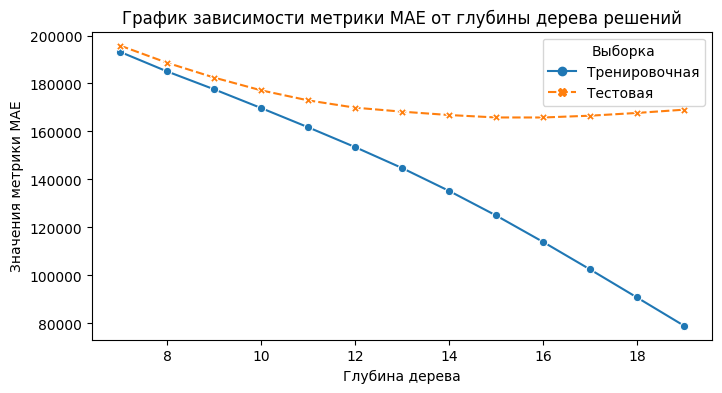

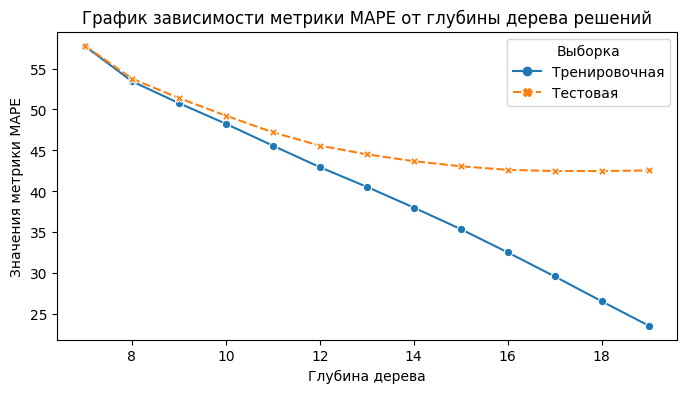

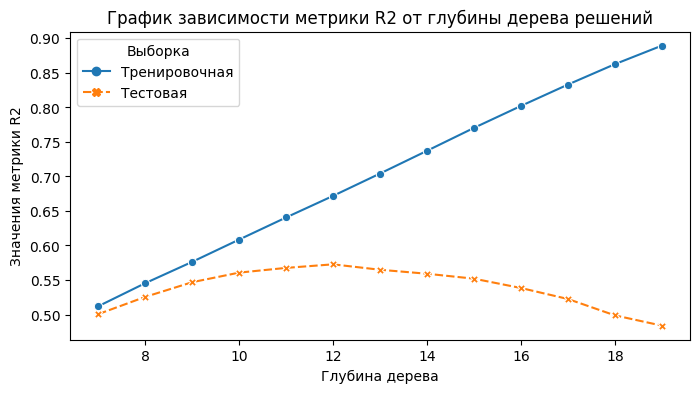

In [123]:
# Подготовим списки с глубиной дерева и для значений метрики
depths = list(np.arange(7, 20))
mae_train_score = []
mae_test_score = []
mape_train_score = []
mape_test_score = []
r2_train_score = []
r2_test_score = []

# Обучим модель с каждым значением глубины дерева и сохраним результаты
for d in depths:
    # Строим и обучаем модель дерева решений
    tree_reg = DecisionTreeRegressor(
        max_depth = d,
        random_state = 42)

    # Обучаем модель
    tree_reg.fit(X_train, y_train)

    # Выполняем предсказание
    y_train_pred = tree_reg.predict(X_train)
    y_test_pred = tree_reg.predict(X_test)

    # Вычисляем метрики качества
    mae_train, mape_train, r2_train, mae_test, mape_test, r2_test\
        = show_metrics(y_train, y_train_pred, y_test, y_test_pred, show = False)

    # Добавим значения метрик в списки
    mae_train_score.append(mae_train)
    mae_test_score.append(mae_test)
    mape_train_score.append(mape_train)
    mape_test_score.append(mape_test)
    r2_train_score.append(r2_train)
    r2_test_score.append(r2_test)


# Преобразуем получившиеся списки в датафреймы
mae_df = pd.DataFrame(
    data = {'Тренировочная': mae_train_score,
            'Тестовая': mae_test_score},
    index = depths)

mape_df = pd.DataFrame(
    data = {'Тренировочная': mape_train_score,
            'Тестовая': mape_test_score},
    index = depths)

r2_df = pd.DataFrame(
    data = {'Тренировочная': r2_train_score,
            'Тестовая': r2_test_score},
    index = depths)

# Построим линейный график зависимости MAE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mae_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости MAPE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mape_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAPE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAPE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости R2
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = r2_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики R2 от глубины дерева решений');
lineplot.set_ylabel('Значения метрики R2');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

Как видно на графике зависимости `MAE`, оптимальной глубиной является 15, после чего метрика на тестовой выборке начинает расти при продолжающей снижаться метрике на тренировочной выборке. Это свидетельствует о переобучении модели.  

Если же мы оптимизируем метрику `MAPE`, то наименьшее значение наблюдается при глубине 18. А вот метрика `R2` перестает улучшаться после глубины 12. Так что в зависимости от задачи, можно выбрать разную глубину.  

Кроме того, можно варьировать параметр минимального количества листьев в узле дерева `min_samples_leaf`, также влияя на результат.  

Давайте обучим дерево с максимальной глубиной 15 и минимальным количеством листьев = 10 и увидим, как изменятся метрики. Зафиксируем, что при глубине 15 сейчас на тестовых выборках они равны:  
- `MAE`: 160206.83,  
- `MAPE`: 42.42%,  
- `R2`: 0.56.  

In [124]:
# Код для просмотра значений метрик при оптимальной глубине
opt_d=15
print('MAE:', mae_test_score[depths.index(opt_d)])
print('MAPE:', mape_test_score[depths.index(opt_d)])
print('R2:', r2_test_score[depths.index(opt_d)])

MAE: 165834.4955821896
MAPE: 43.047639644009
R2: 0.5519176535644614


In [125]:
# Строим и обучаем модель дерева решений
tree_reg = DecisionTreeRegressor(
    max_depth = 15,
    min_samples_leaf = 10,
    random_state = 42)

# Обучаем модель
%time tree_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1.02 s
Wall time: 1.02 s
MAE на тренировочоной выборке: 143573.29
MAPE на тренировочной выборке: 38.44
r2 на тренировочоной выборке: 0.7

MAE на тестовой выборке: 163358.62
MAPE на тестовой выборке: 42.61
r2 на тестовой выборке: 0.6


>**Выводы по модели решающего дерева:**  
>
> Видно, что благодаря введению дополнительного параметра модели - минимального количества листьев, нам удалось еще улучшить две из трех метрик: `MAPE` несколько ухудшилась, поскольку глубина 15 не была для нее оптимальной. Как, впрочем, и для `R2`, но тут доп. параметр нивелировал неоптимальное значение глубины.  
>
> Перейдем к более сложным моделям, где сможем провести подбор гиперпараметров в автоматическом режиме.  

### 6.3. Случайный лес и оптимизация гиперпараметров  

Посмотрим на возможности случайного леса и вопользуемся алгоритмом RandomizedSearchCV.  

In [126]:
# Создаем сетку перебираемых параметров
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': np.arange(11, 18, 2),
    'min_samples_leaf': [5, 10, 15]
}

# Создаем модель RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator = RandomForestRegressor(
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    param_distributions = param_distributions,
    cv = 2,
    scoring = 'r2',
    return_train_score = False,
    n_jobs = -1,
    verbose = 1
)

# Обучим модель
%time rand_search.fit(X_train, y_train)

# Сделаем предсказания
y_train_pred = rand_search.predict(X_train)
y_test_pred = rand_search.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


CPU times: total: 2min 17s
Wall time: 3min 33s
MAE на тренировочоной выборке: 130612.83
MAPE на тренировочной выборке: 36.3
r2 на тренировочоной выборке: 0.76

MAE на тестовой выборке: 150535.05
MAPE на тестовой выборке: 40.44
r2 на тестовой выборке: 0.66


In [127]:
# Выведем подобранные значения гиперпараметров, использованные для прогноза
print('Наилучшие значения гиперпараметров:', rand_search.best_params_)

Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 15}


>**Выводы по модели случайного леса:**  
>
> Более сложная модель - лучшие результаты. В том числе и благодаря алгоритму подбора оптимальных гиперпараметров.  
>
> Отметим, что начинает играть роль фактор времени обучения модели. Хотя в данном случае решающее влияние оказал алгоритм пусть и случайного, но перебора гиперпараметров. Мы видим, как это становится важным при больших датафреймах.
>
> Зафиксируем оптимальные гиперпараметры - они пригодятся нам в модели стекинга ниже.  

### 6.4. Градиентный бустинг над деревьями решений  

Мы видели ранее, что решающее дерево "проигрывает" случайному лесу. Посмотрим, чего мы сможем добиться с помощью бустинга.  

In [128]:
# Строим модель градиентного бустинга
boo_reg = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 15,
    min_samples_split = 20,
    random_state = 42
)

# Обучаем модель
%time boo_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = boo_reg.predict(X_train)
y_test_pred = boo_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1min 53s
Wall time: 1min 53s
MAE на тренировочоной выборке: 86465.72
MAPE на тренировочной выборке: 24.85
r2 на тренировочоной выборке: 0.9

MAE на тестовой выборке: 139505.44
MAPE на тестовой выборке: 36.46
r2 на тестовой выборке: 0.7


>**Выводы по модели градиентного бустинга:**  
>
> Итак, последовательное уменьшение ошибки меньшим количеством деревьев, принесло лучшие результаты, чем большее число деревьев в случайном лесу: `R2` = 0.69, `MAPE` = 36%.  
>
> Есть, правда, опасение, что модель могла немного переобучиться, раз она демонстрирует настолько высокий показатель `R2` = 0.9 на тренировочной выборке. Однако, поскольку две другие метрики не спустились до нуля, отбросим это опасение.  
>
> Узнаем, какие признаки из нашего датафрейма оказались наиболее значимыми.    

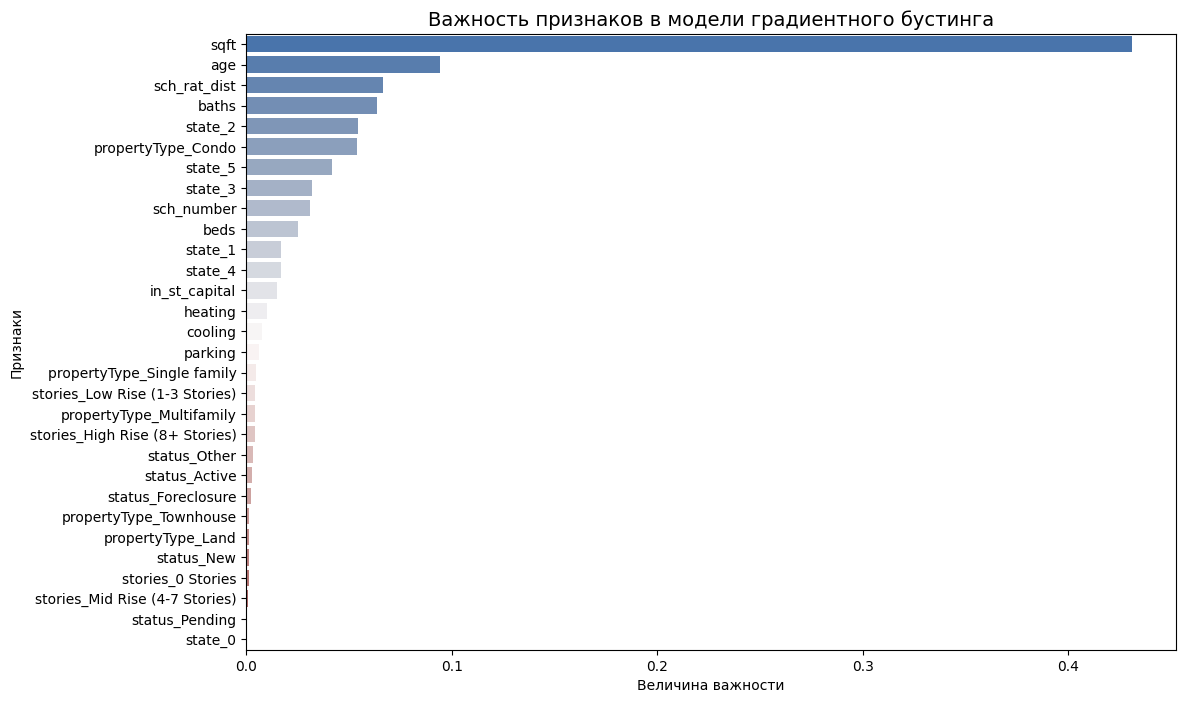

In [129]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
gb_feat = pd.Series(boo_reg.feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Площадь объекта недвижимости "sqft" - стала самым важным признаком с большим отрывов от остальных. А вот признак "status Foreclosure", который был определен тестом хи-квадрат как наиболее важный среди категориальных признаков, опустился в самый низ рейтинга.  

Вероятнее всего, на результаты градиентного бустинга не повлияло бы, если бы мы все-таки удалили признаки "stories_0 Stories" и "propertyType_Land", на которые нам указывал SelectKBest: они расположились на 3-м и 4-м местах соответственно, но снизу рейтинга.  

Ожидаемо, что покупателям важен возраст недвижимости (2-е место). Интересно, что количество ванных комнат волнует будущих жильцов гораздо больше, чем количество спален.

Между ванными и спальнями расположился признак количества школ в окрестности. А вот их совокупный рейтинг и расстояние до них - на 3-м месте! Даже признак расположения в столице штата, несмотря на наши предположения, оказался в верхней части рейтинга. Таким образом, наши усилия, затраченные на генерацию данных признаков на этапе EDA оправдали себя.

Попробуем теперь еще улучшить наши результаты с использованием метода оптимизации гиперпараметров.  

### 6.5. Стэкинг моделей  

Попробуем объединить "усилия" трех моделей с помощью стекинга и посмотрим, удастся ли нам достичь более высоких результатов, чем при их индивидуальном использовании.  

Обучим знакомые нам модели с их оптимальными гиперпараметрами.  

In [130]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth = 15,
        min_samples_leaf = 10,
        random_state = 42)
    ),
    ('rf', RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42)
    ),
    ('gb', GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 100,
        max_depth = 15,
        min_samples_split = 20,
        random_state = 42)
    )
]

# Создаем объект класса стекинг
stack_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    cv = 2,
    n_jobs = -1,
    verbose = 5
)

# Обучаем модель
%time stack_reg.fit(X_train, y_train)

# Делаем предсказание
y_train_pred = stack_reg.predict(X_train)
y_test_pred = stack_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 3min 20s
Wall time: 3min 42s
MAE на тренировочоной выборке: 97505.8
MAPE на тренировочной выборке: 26.87
r2 на тренировочоной выборке: 0.86

MAE на тестовой выборке: 141484.65
MAPE на тестовой выборке: 36.69
r2 на тестовой выборке: 0.69


>**Выводы по модели стеккинга:**  
>
> Как ни странно, три независимые модели (включая наиболее успешную - градиентный бустиг) не смогли сколь-нибудь значимо улучшить постигнутые показатели. `MAPE` осталась на том же уровне, `MAE` ухудшилась на \$2 тыс., а `R2` снизилась на одну сотую.  
>
> Таким образом, лидирует градиентный бустинг.  

### 6.6. CatBoostRegressor и Optuna  

Воспользуемся  CatBoostRegressor, которую мы применили на этапе baseline-решения.  

In [131]:
# Создадим функцию расчета целевой метрики
def optuna_rf(trial,
              cv: int = 3,
              X: pd.DataFrame = X_train,
              y: pd.Series = y_train) -> float:
    """Функция получает объект trial, выборки и другие параметры и возвращает
    значение целевой метрики для модели CatBoostRegressor.

    Args:
        trial : объект Optuna.trial для сохранения результатов оптимизации
        cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 3
        X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train
        y (pd.Series, optional): вектор ответов; по умолчанию = y_train

    Returns:
        float: значение целевой метрики
    """

    # Задаем пространство поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 20, 50, 10)
    depth = trial.suggest_int('depth', 11, 15, 2)
    learning_rate = trial.suggest_float('learning_rate', 0.3, 1.0, step=0.1)

    # Cоздаем модель CatBoostRegressor
    model = CatBoostRegressor(
        iterations = iterations,
        depth = depth,
        learning_rate = learning_rate,
        loss_function = 'RMSE',
        random_state = 42,
        thread_count = -1,
        boosting_type = 'Plain',
        verbose = False
    )

    # Готовим выборки для подачи в модель в виде класса Pool
    train_pool = Pool(X, y)

    # Обучаем модель с помощью кросс-валидации
    model.fit(train_pool)
    score = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()

    # Возвращаем значение метрики
    return score

In [132]:
# Создаем объект исследования study для подбора гиперпараметров
study = optuna.create_study(study_name='CatBoostRegressor', direction='maximize')

# Выполняем оптимизацию гиперпараметров 10 раз
%time study.optimize(optuna_rf, n_trials=10)

[I 2023-11-06 11:10:25,169] A new study created in memory with name: CatBoostRegressor
[I 2023-11-06 11:10:29,974] Trial 0 finished with value: 0.6561143702632931 and parameters: {'iterations': 30, 'depth': 11, 'learning_rate': 0.4}. Best is trial 0 with value: 0.6561143702632931.
[I 2023-11-06 11:11:01,952] Trial 1 finished with value: 0.6658509432473451 and parameters: {'iterations': 30, 'depth': 15, 'learning_rate': 0.5}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:11:33,958] Trial 2 finished with value: 0.6550137286337425 and parameters: {'iterations': 30, 'depth': 15, 'learning_rate': 0.7}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:11:50,500] Trial 3 finished with value: 0.6501686014309955 and parameters: {'iterations': 50, 'depth': 13, 'learning_rate': 0.8}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:11:57,467] Trial 4 finished with value: 0.6568701299954409 and parameters: {'iterations': 20, 'depth': 13, 'learning

CPU times: total: 3min 28s
Wall time: 2min 25s


In [133]:
# Продолжим подбор гиперпараметров: добавим еще 10 итераций
%time study.optimize(optuna_rf, n_trials=10)

[I 2023-11-06 11:13:30,767] Trial 10 finished with value: 0.6243317426876196 and parameters: {'iterations': 40, 'depth': 15, 'learning_rate': 1.0}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:13:35,966] Trial 11 finished with value: 0.6618511910916992 and parameters: {'iterations': 40, 'depth': 11, 'learning_rate': 0.3}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:13:41,052] Trial 12 finished with value: 0.6618511910916992 and parameters: {'iterations': 40, 'depth': 11, 'learning_rate': 0.3}. Best is trial 1 with value: 0.6658509432473451.
[I 2023-11-06 11:14:20,834] Trial 13 finished with value: 0.6698859650650734 and parameters: {'iterations': 40, 'depth': 15, 'learning_rate': 0.4}. Best is trial 13 with value: 0.6698859650650734.
[I 2023-11-06 11:14:50,634] Trial 14 finished with value: 0.6658509432473451 and parameters: {'iterations': 30, 'depth': 15, 'learning_rate': 0.5}. Best is trial 13 with value: 0.6698859650650734.
[I 2023-11-06 11:1

CPU times: total: 7min 43s
Wall time: 5min 30s


In [134]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров:', study.best_params)
print('r2 на тренировочной выборке:', round(study.best_value, 2))

Наилучшие значения гиперпараметров: {'iterations': 50, 'depth': 15, 'learning_rate': 0.4}
r2 на тренировочной выборке: 0.67


In [135]:
# Для тестовой выборки обучим модель с наилучшими параметрами и выведем результаты
cat_boo_reg = CatBoostRegressor(**study.best_params,
                                thread_count = -1,
                                boosting_type = 'Plain',
                                verbose = False,
                                random_state = 42)

# Готовим выборки для подачи в модель в виде класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Обучаем модель
%time cat_boo_reg.fit(train_pool)

# Делаем предсказание
y_train_pred = cat_boo_reg.predict(train_pool)
y_test_pred = cat_boo_reg.predict(test_pool)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1min 8s
Wall time: 18.3 s
MAE на тренировочоной выборке: 126262.02
MAPE на тренировочной выборке: 34.24
r2 на тренировочоной выборке: 0.78

MAE на тестовой выборке: 146527.43
MAPE на тестовой выборке: 38.58
r2 на тестовой выборке: 0.68


>**Выводы по модели CatBoostRegressor:**  
>
> Несмотря на многообещающие результаты модели в baseline-решении, хорошо обработанные нами данные вкупе с многоэтапным подбором параметров с помощью Optuna не принесли ожидаемого улучшения метрик.  
> Более того, полученные значения даже несколько уступают модели градиентного бустинга.

In [136]:
# Построим график оптимизации метрики R@
optuna.visualization.plot_optimization_history(study, target_name='R2')

In [137]:
# Построим диаграмму важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name='R2')

In [138]:
# Построим тепловые карты влияния гиперпараметров на метрику R2
optuna.visualization.plot_contour(study, params=['iterations', 'depth', 'learning_rate'],
                                  target_name='R2')

Несмотря на отличительную особеность библиотеки Optuna продолжать оптимизацию гиперпараметров после завершения первых заданных итераций, мы видим, что после 10-й итерации дальнейшего улучшения не последовало.  
Возможно, дело в малом количестве оптимизируемых гиперпараметров и их диапазоне значений. 


Посмотрим на значимость признаков в модели CatBoostRegressor.  

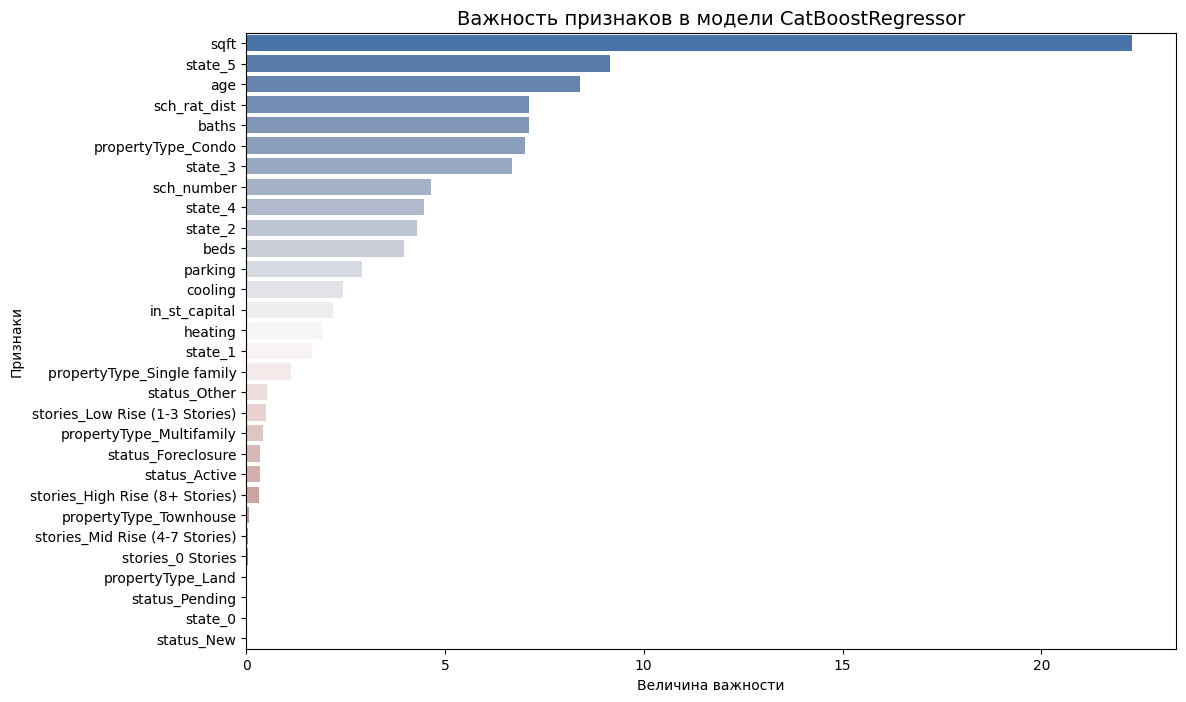

In [139]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
cat_bst_feat = pd.Series(cat_boo_reg.get_feature_importance(),
                         index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = cat_bst_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели CatBoostRegressor', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Можно заметить, что признак "sqft" не имеет такого явного отрыва от остальных, как в модели градиентного бустинга. Убывание значимости происходит плавнее, и признаки имеют большую значимость.  

> **Общий вывод по 6-му разделу (Evaluation):**
>
> Сведем в таблицу все полученные результаты, чтобы проще было оценить эффективность тех или иных моделей.  


| Модель | R2 | MAPE | MAE |  
|---|---:|---:|---:|   
| LinearRegression | 0.43 | 63.85  | 215474.63 |  
| PolynomialRegression | 0.56 | 53.18 | 184577.51  |  
| DecisionTreeRegressor | 0.6 | 42.61 | 163358.29 |  
| RandomForestRegressor | 0.69 | 36.69 | 141484.65 |  
| **GradientBoostingRegressor** | **0.7** | **36.46** | **139505.44** |  
| StackingRegressor | 0.69 | 36.69 | 141484.65 |  
| CatBoostRegressor | 0.68 | 38.9 | 147456.85 |  


  
> 
Таблица хорошо иллюстрирует, как с возрастанием сложности моделей и алгоритмов растут и результаты. В нашем случае пик пришелся на модель градиентного бустинга, и именно ее мы и используем в продакшене на следующем этапе.
>
> На этом мы завершим этап решения задачи регрессии.
___

## 7. Подготовка модели к продакшену (Preparation for deployment)   

С помощью библиотеки Pickle мы сериализуем обученную модель градиентного бустинга и сохраним ее в файл. Его останется только открыть и развернуть на сервере, чтобы выполнять прогнозы стоимости недвижимости.  

Для проверки корректности работы модели, развернутой на сервере, ниже приводится предсказание на тестовом наборе (состоящем из одной записи из выборки X_test). Точно такой же набор будет подан на сервер клиентским приложением. Ответ должен совпасть.  

In [140]:
# Производим сериализацию обученной модели
model = pickle.dumps(boo_reg) 

print(type(model))
print(type(boo_reg))


<class 'bytes'>
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [141]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('myfile.pkl', 'wb') as output:
    pickle.dump(boo_reg, output)

In [ ]:
# Задаем тестовый набор
test_data = [2,1820,3,1,0,1,4,7,3,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1]
test_data = np.array(test_data).reshape(1, -1) # преобразуем в датафрейм

# Выполняем предсказание с помощью обученной модели
prediction = boo_reg.predict(test_data)

# Выводим результат на экран для проверки при запуске на сервере
print('Такое предсказание должен вернуть сервер:', round(prediction[0]))

Такое предсказание должен вернуть сервер: 501626


2023-11-06 11:55:47,089 - INFO     - Executing shutdown due to inactivity...
2023-11-06 11:55:59,361 - INFO     - Executing shutdown...
2023-11-06 11:55:59,363 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "c:\Users\Islam\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\Islam\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\Islam\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\Islam\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "c:\Users\Islam\AppData\Local\Programs\Python\Python39\li

___

## 8. Выводы по проекту  

1. На протяжении проекта мы прошли через все этапы модели CRISP-DM.  
2. Движение по модели CRISP-DM означает, что, получив первые результаты моделирования, мы возвращались к предыдущим этапам очистки и подготовки данных, создавали новые, изменяли критерии фильтрации записей и отбора признаков. Это позволило в конечном счете достичь более высоких результатов.  
3. Все стоявшие перед нами задачи, выполнены. И, несмотря на результаты, которые еще можно было бы улучшить, проект можно считать успешно завершенным.  
4. В качестве возможных шагов повышения качества моделирования, как мы сказали выше, стоит уделить больше времени подготовке данных, например:  
    - разделить на большее количество категорий типы недвижимости,  
    - выделить ценовые категории недвижимости,  
    - применить алгоритмы кластеризации для выделения групп жилья по иным критериям,  
    - детальнее проработать признак со школами,  
    - добавить в датафрейм новые данные в том числе на основании признака "street" (близость магазинов, автозаправок, мест развлечений; шумных автострад, аэропортов, вредных производств и т.д.).  
5. Наконец, можно применить не задействованные алгоритмы и методы обработк данных.  
___